tgb - 11/29/2021 - Generates high-resolution figures (in `pdf` format) for the climate-invariant ML manuscript

Make sure you are using the right Python environment, for instance this one: [https://github.com/tbeucler/CBRAIN-CAM/blob/master/cbrain/env_cpu.yml]. 

You can refer to this page [https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file] to create a conda environment from a `yml` file, noting that it is usually impossible to get the exact same version of the packages because of frequent conda updates.  

*Replace the path below with the folder containing the figure data*

In [1]:
path_Fig = '/DFS-L/DATA/pritchard/tbeucler/SPCAM/SPCAM_PHYS/CIML_Fig_Data/'

# Import

In [ ]:
import xarray as xr
import numpy as np
import math

import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import matplotlib.image as imag
import matplotlib.ticker as mticker
import matplotlib.transforms as mtrans
from matplotlib.ticker import NullFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.ticker import MaxNLocator

import pickle

import warnings

# Fig2

## Load data

In [28]:
STaqua_m4K = xr.open_dataset(path_Fig+'Sample_SPCAM3_m4K.nc')
STaqua_0K = xr.open_dataset(path_Fig+'Sample_SPCAM3_p0K.nc')
STaqua_p4K = xr.open_dataset(path_Fig+'Sample_SPCAM3_p4K.nc')

ST_m4K = xr.open_dataset(path_Fig+'Sample_SPCAM5_m4K.nc')
ST_0K = xr.open_dataset(path_Fig+'Sample_SPCAM5_p0K.nc')
ST_p4K = xr.open_dataset(path_Fig+'Sample_SPCAM5_p4K.nc')

In [14]:
hf = open(path_Fig+'SPCAM5_annual_mean_SST.pkl','rb')
ST_mean = pickle.load(hf)
hf.close()

In [15]:
hf = open(path_Fig+'SAM_coordinates.pkl','rb')
coor_HH = pickle.load(hf)
hf.close()

In [17]:
hf = open(path_Fig+'Sample_SAM_Subgrid.pkl','rb')
inpoup_HH = pickle.load(hf)
hf.close()

In [32]:
with open(path_Fig+'SAM_SST') as f:
    TS_HH_lines = f.readlines()

TS_HH = []
for s in TS_HH_lines: 
    TS_HH.append(float(s))
    
TS_HH = np.array(TS_HH)

inpoup_HH['TS'] = {}
inpoup_HH['TS']['qobs'] = np.tile(np.expand_dims(TS_HH,axis=1),inpoup_HH['T_xy']['qobs'].shape[1])
inpoup_HH['TS']['qobs4K'] = inpoup_HH['TS']['qobs']+4

## Create colorbars

In [20]:
vmin0_SST = 270
vmax0_SST = 310

In [21]:
# Create custom colormap following [https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar]
cmap = plb.cm.coolwarm
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap_SST = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = np.linspace(vmin0_SST, vmax0_SST, 11)
norm_SST = mpl.colors.BoundaryNorm(bounds, cmap.N)

In [22]:
vmin0_SGS = -15
vmax0_SGS = 15

In [23]:
# Create custom colormap following [https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar]
cmap = plb.cm.coolwarm
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap_SGS = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = np.linspace(vmin0_SGS, vmax0_SGS, 101)
norm_SGS = mpl.colors.BoundaryNorm(bounds, cmap.N)

## Plot all maps together

In [78]:
# CBAR_position = [0.07, 0.525, 0.01, 0.35]
# CBAR2_position = [0.07, 0.135, 0.01, 0.35]
CBAR_position = [0.87, 0.525, 0.01, 0.35]
CBAR2_position = [0.87, 0.135, 0.01, 0.35]
it = 13; # Time index to select subgrid heating
ip = 18; # Pressure index to select 500-hPa level
Y0 = 1.5; # Position of the text above the subplots
X1 = -0.125; # Position of (a) and (b)
Y1 = 1.25; # Position of (a) and (b)

In [79]:
fz = 12
lw = 4
siz = 100

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw

In [80]:
Titles = ['SPCAM3','SPCAM5','SAM']

Not available
Not available


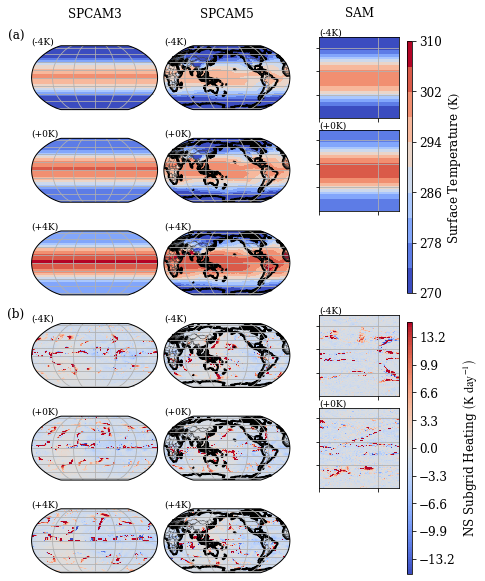

In [81]:
fig, ax = plt.subplots(6,3,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)},figsize=(7,10))

TEXT = {}
for isub in range(6): # Loop over 6 subplots
    
    icol = isub-3*math.floor(isub/3) # Determine location of subplot (out of 6)
    if math.floor(isub/3)==0: cmap0 = cmap_SST; norm0 = norm_SST; vmin0 = vmin0_SST; vmax0 = vmax0_SST;
    else: cmap0 = cmap_SGS; norm0 = norm_SGS; vmin0 = vmin0_SGS; vmax0 = vmax0_SGS;
    
    for iax in range(3): # In each subplot, loop over 3 climates (from top to bottom)
        
        if iax==0: 
            if isub%3==0: HH = False; data = STaqua_m4K;
            elif isub%3==1: data = ST_m4K;
            elif isub%3==2: HH = True; Avail=True; dataset = 'qobs';
            if isub==1: toplot = ST_mean['st_m4K'];
            tit = '(-4K)'
        elif iax==1: 
            if isub%3==0: HH = False; data = STaqua_0K;
            elif isub%3==1: data = ST_0K; 
            elif isub%3==2: HH = True; Avail=True; dataset = 'qobs4K';
            if isub==1: toplot = ST_mean['st_0K'];
            tit = '(+0K)'
        elif iax==2: 
            if isub%3==0: HH = False; data = STaqua_p4K;
            elif isub%3==1: data = ST_p4K; 
            elif isub%3==2: HH=True; Avail=False;
            if isub==1: toplot = ST_mean['st_p4K'];
            tit = '(+4K)'
        
        if isub==0: toplot = data.TS.mean(dim='time')
        elif isub==2: toplot = 'TS'
        elif isub==3: toplot = 24*3600*data.TPHYSTND[it,ip,:,:]
        elif isub==4: toplot = 24*3600*data.PTTEND[it,ip,:,:]
        elif isub==5: toplot = 'Tout_482'

        irow = iax+3*math.floor(isub/3) # To make 6 panels
        
        if HH:
            ax[irow][icol].remove()
            
            if Avail:
                ax[irow][icol] = fig.add_subplot(6,3,3*irow+icol+1)
                imag = ax[irow][icol].pcolormesh(coor_HH['x'],coor_HH['y'],
                                                 inpoup_HH[toplot][dataset],
                                                 cmap=cmap0,norm=norm0,
                                                 vmin=vmin0,vmax=vmax0)
#                 imag = ax[irow][icol].matshow(inpoup_HH[toplot][dataset],
#                                               cmap=cmap0,norm=norm0,
#                                               vmin=vmin0,vmax=vmax0)
                ax[irow][icol].set_aspect(0.4) # equal aspect ratio makes it hard to read
# so this is a compromise to avoid overly stretching the channel in the x-direction
                ax[irow][icol].grid()
                ax[irow][icol].xaxis.set_ticklabels([])
                ax[irow][icol].yaxis.set_ticklabels([])
                ax[irow][icol].set_title(tit,loc='left',pad=-0.1,fontsize=3*fz/4)
            else:
                tit = ''
                print('Not available')

        else:
            imag = ax[irow][icol].pcolormesh(data.lon, data.lat, 
                                             toplot,cmap=cmap0, norm=norm0,
                                             transform=ccrs.PlateCarree(),
                                             vmin=vmin0,vmax=vmax0)
            ax[irow][icol].gridlines()
            ax[irow][icol].set_title(tit,loc='left',pad=-0.1,fontsize=3*fz/4)
        if icol%3==1:
                ax[irow][icol].coastlines(linewidth=2.0,edgecolor='0.25')
                ax[irow][icol].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
        
        # Colorbar
        if isub==0 and iax==0:
            cbar_ax = fig.add_axes(CBAR_position)
            CBAR = fig.colorbar(imag, label="Surface Temperature "+r'$\left(\mathrm{K}\right)$', 
                                cax=cbar_ax)
            cbar_ax.yaxis.set_ticks_position('right')
            cbar_ax.yaxis.set_label_position('right')
        elif isub==3 and iax==0:
            cbar2_ax = fig.add_axes(CBAR2_position)
            fig.colorbar(imag, label="NS Subgrid Heating "+r'$\left(\mathrm{K\ day^{-1}}\right)$', 
                         cax=cbar2_ax)
            cbar2_ax.yaxis.set_ticks_position('right')
            cbar2_ax.yaxis.set_label_position('right')
        
        # Title of each column
        plt.draw()
        if iax==0:

            if isub<3:
                TEXT[isub]= ax[0][isub].text(0.5,Y0,Titles[isub],fontsize=fz,
                             va='center',ha ='center',transform = ax[0][isub].transAxes)
        # (a) and (b) subplots
        if isub==0:
            if iax==0: ax[0][isub].text(X1,Y1,'(a)',fontsize=fz,va='top',ha='center',
                                       transform = ax[0][isub].transAxes)
        elif isub==3: 
            if iax==0: ax[irow][icol].text(X1,Y1,'(b)',fontsize=fz,va='top',ha='center',
                                       transform = ax[irow][icol].transAxes)

plt.subplots_adjust(wspace=0.05, hspace=0.15)
TEXT[2].set_position((0.5,1.3))
plt.savefig(path_Fig+'Fig2.pdf', format='pdf')

# Fig 4

## Load data

Load

In [344]:
hf = open(path_Fig+'SPCAM_Q_histogram.pkl','rb')
Q_data = pickle.load(hf)
hf.close()

In [345]:
hf = open(path_Fig+'SPCAM_T850_histogram.pkl','rb')
T850_data = pickle.load(hf)
hf.close()

In [346]:
hf = open(path_Fig+'SPCAM_T150_histogram.pkl','rb')
T150_data = pickle.load(hf)
hf.close()

In [347]:
hf = open(path_Fig+'SPCAM_B_histogram.pkl','rb')
B_data = pickle.load(hf)
hf.close()

In [348]:
hf = open(path_Fig+'SPCAM_LHF_histogram.pkl','rb')
LHF_data = pickle.load(hf)
hf.close()

In [349]:
hf = open(path_Fig+'SAM_Q_histogram.pkl','rb')
Q_data_HH = pickle.load(hf)
hf.close()

HHdic = {}
HHdic['QV'] = 'qv';
HHdic['RH'] = 'RH';
HHdic['QfromQsat'] = 'q_deficit'

In [350]:
hf = open(path_Fig+'SAM_T850_histogram.pkl','rb')
T850_data_HH = pickle.load(hf)
hf.close()

hf = open(path_Fig+'SAM_T150_histogram.pkl','rb')
T150_data_HH = pickle.load(hf)
hf.close()

HHdic['T'] = 'Tin'
HHdic['BMSE'] = 'BMSE'
HHdic['TfromNS'] = 'T_mTNS'

Group in structure

In [351]:
path_array = [
     '2021_03_18_O3_TRAIN_M4K_shuffle.nc',
     '2021_01_24_O3_TRAIN_shuffle.nc',
     '2021_03_18_O3_TRAIN_P4K_shuffle.nc',
     '2021_04_18_RG_TRAIN_M4K_shuffle.nc',
     '2021_06_03_RG_TRAIN_shuffle.nc',
     '2021_04_18_RG_TRAIN_P4K_shuffle.nc',
]

In [352]:
hisQ = {}
edgQ = {}

for ikey,key in enumerate(['QV','RH','QfromQsat']):
    hisQ[key] = {}
    edgQ[key] = {}
    for ipath,path in enumerate(path_array):
        hisQ[key][path] = {}
        edgQ[key][path] = {}

In [353]:
hisT = {}
edgT = {}

for ikey,key in enumerate(['T','BCONS','TfromNS']):
    hisT[key] = {}
    edgT[key] = {}
    for ipath,path in enumerate(path_array):
        hisT[key][path] = {}
        edgT[key][path] = {}

In [354]:
hisT150 = {}
edgT150 = {}

for ikey,key in enumerate(['T','BCONS','TfromNS']):
    hisT150[key] = {}
    edgT150[key] = {}
    for ipath,path in enumerate(path_array):
        hisT150[key][path] = {}
        edgT150[key][path] = {}

In [355]:
hisT200 = {}
edgT200 = {}

for ikey,key in enumerate(['T','BCONS','TfromNS']):
    hisT200[key] = {}
    edgT200[key] = {}
    for ipath,path in enumerate(path_array):
        hisT200[key][path] = {}
        edgT200[key][path] = {}

In [356]:
hisLHF = {}
edgLHF = {}

for ikey,key in enumerate(['LHF','LHF_nsQ','LHF_nsDELQ']):
    hisLHF[key] = {}
    edgLHF[key] = {}
    for ipath,path in enumerate(path_array):
        hisLHF[key][path] = {}
        edgLHF[key][path] = {}

In [357]:
hisQ = Q_data['hisQ']
edgQ = Q_data['edgQ']
# Convert specific humidities to g/kg
for ipath,path0 in enumerate(path_array):
    for ikey,key in enumerate(['QV','QfromQsat']):
        edgQ[key][path0] *= 1e3

In [358]:
hisT = T850_data['hisT']
edgT = T850_data['edgT']
# Load buoyancy from MSE
ilevB = 23
for ikey,key in enumerate(['BMSE']):
    hisT[key] = {}
    edgT[key] = {}
    for ipath,path in enumerate(path_array):
        hisT[key][path] = B_data['hisT'][ilevB][path]
        edgT[key][path] = B_data['edgT'][ilevB][path]
        
hisT150 = T150_data['hisT']
edgT150 = T150_data['edgT']
# Load buoyancy from MSE
ilevB = 10
for ikey,key in enumerate(['BMSE']):
    hisT150[key] = {}
    edgT150[key] = {}
    for ipath,path in enumerate(path_array):
        hisT150[key][path] = B_data['hisT'][ilevB][path]
        edgT150[key][path] = B_data['edgT'][ilevB][path]

# Redefine Tarray to replace BCONS with BMSE for now
Tarray = ['T','BMSE','TfromNS']

hisLHF = LHF_data['hisLHF']
edgLHF = LHF_data['edgLHF']

Set histograms to zero for the (-4K) SAM simulations and load Janni values for the other sims

In [359]:
path_array = [
     '2021_03_18_O3_TRAIN_M4K_shuffle.nc',
     '2021_01_24_O3_TRAIN_shuffle.nc',
     '2021_03_18_O3_TRAIN_P4K_shuffle.nc',
     '2021_04_18_RG_TRAIN_M4K_shuffle.nc',
     '2021_06_03_RG_TRAIN_shuffle.nc',
     '2021_04_18_RG_TRAIN_P4K_shuffle.nc',
    '1','2','3' # dummy paths for HH simulations
]

In [360]:
def edg2bin(bin_edges):
    return 0.5*(bin_edges[1:]+bin_edges[:-1])

In [361]:
path_SAM = ['1','2','3']
for ipath,path0 in enumerate(path_SAM):
    
    for ikey,key in enumerate(['QV','RH','QfromQsat']):
        if ipath==2: 
            edgQ[key][path0] = Q_data_HH['edgQ'][HHdic[key]]['qobs']
            hisQ[key][path0] = 0*edg2bin(edgQ[key][path0])**0
        elif ipath==0: 
            hisQ[key][path0] = Q_data_HH['hisQ'][HHdic[key]]['qobs']
            if key=='RH': edgQ[key][path0] = Q_data_HH['edgQ'][HHdic[key]]['qobs']
            else: edgQ[key][path0] = 1e3*Q_data_HH['edgQ'][HHdic[key]]['qobs'] # Conversion in g/kg
        elif ipath==1: 
            hisQ[key][path0] = Q_data_HH['hisQ'][HHdic[key]]['qobs4K']
            if key=='RH': edgQ[key][path0] = Q_data_HH['edgQ'][HHdic[key]]['qobs4K']
            else: edgQ[key][path0] = 1e3*Q_data_HH['edgQ'][HHdic[key]]['qobs4K'] # Conversion in g/kg
    
    for ikey,key in enumerate(['T','BMSE','TfromNS']):
        if ipath==2: 
            edgT[key][path0] = T850_data_HH['edgQ'][HHdic[key]]['qobs']
            hisT[key][path0] = 0*edg2bin(edgT[key][path0])**0
            edgT150[key][path0] = T150_data_HH['edgQ'][HHdic[key]]['qobs']
            hisT150[key][path0] = 0*edg2bin(edgT150[key][path0])**0
        elif ipath==0: 
            hisT[key][path0] = T850_data_HH['hisQ'][HHdic[key]]['qobs']
            edgT[key][path0] = T850_data_HH['edgQ'][HHdic[key]]['qobs']
            hisT150[key][path0] = T150_data_HH['hisQ'][HHdic[key]]['qobs']
            edgT150[key][path0] = T150_data_HH['edgQ'][HHdic[key]]['qobs']
        elif ipath==1: 
            hisT[key][path0] = T850_data_HH['hisQ'][HHdic[key]]['qobs4K']
            edgT[key][path0] = T850_data_HH['edgQ'][HHdic[key]]['qobs4K']
            hisT150[key][path0] = T150_data_HH['hisQ'][HHdic[key]]['qobs4K']
            edgT150[key][path0] = T150_data_HH['edgQ'][HHdic[key]]['qobs4K']
            
    for ikey,key in enumerate(['LHF','LHF_nsQ','LHF_nsDELQ']):
            edgLHF[key][path0] = np.linspace(0,100,101)
            hisLHF[key][path0] = 0*edg2bin(edgLHF[key][path0])**0

## Plot all PDFs together

In [375]:
YLAB = {}

YLAB[0] = {}
# YLAB[0]['QV'] = '$q\\ \\left[\\mathrm{g\\ kg^{-1}}\\right]$'
# YLAB[0]['RH'] = '$\\mathrm{RH}\\ \\left[1\\right]$'
# YLAB[0]['QfromQsat'] = '$q_{\\mathrm{deficit}}\\ \\left[\\mathrm{g\\ kg^{-1}}\\right]$'
YLAB[0]['QV'] = '$q$'
YLAB[0]['RH'] = '$\\mathrm{RH}$'
YLAB[0]['QfromQsat'] = '$q_{\\mathrm{deficit}}$'

YLAB[1] = {}
# YLAB[1]['T'] = '$T\\ \\left[\\mathrm{K}\\right]$'
# YLAB[1]['BMSE'] = '$B_{\\mathrm{plume}}\\ \\left[\\mathrm{m\\ s^{-2}}\\right]$'
# YLAB[1]['TfromNS'] = '$T_{\\mathrm{from\\ NS}}\\ \\left[\\mathrm{K}\\right]$'
YLAB[1]['T'] = '$T$'
YLAB[1]['BMSE'] = '$B_{\\mathrm{plume}}$'
YLAB[1]['TfromNS'] = '$T_{\\mathrm{from\\ NS}}$'

YLAB[2] = {}
# YLAB[2]['LHF'] = '$\\mathrm{LHF}\\ \\left[\\mathrm{W\\ m^{-2}}\\right]$'
# YLAB[2]['LHF_nsQ'] = '$\\mathrm{LHF}_{q}\\ \\left[\\mathrm{kg\\ m^{-2}s^{-1}}\\right]$'
# YLAB[2]['LHF_nsDELQ'] = '$\\mathrm{LHF}_{\\Delta q}\\ \\left[\\mathrm{kg\\ m^{-2}\\ s^{-1}}\\right]$'
YLAB[2]['LHF'] = '$\\mathrm{LHF}$'
YLAB[2]['LHF_nsQ'] = '$\\mathrm{LHF}_{q}$'
YLAB[2]['LHF_nsDELQ'] = '$\\mathrm{LHF}_{\\Delta q}$'

In [376]:
Y0 = [1.2,0.95,1]
delY = 5e-3
# TITLE = ["Aquaplanet (SPCAM3)","Earth-like (SPCAM5)","Hypohydrostatic (SAM)"]
TITLE = ["SPCAM3","SPCAM5","SAM"]
PANEL = ['(a)','(b)','(c)']

In [364]:
path_aqua = [
     '2021_03_18_O3_TRAIN_M4K_shuffle.nc',
     '2021_01_24_O3_TRAIN_shuffle.nc',
     '2021_03_18_O3_TRAIN_P4K_shuffle.nc'
]
path_RG = [
    '2021_04_18_RG_TRAIN_M4K_shuffle.nc',
    '2021_06_03_RG_TRAIN_shuffle.nc',
    '2021_04_18_RG_TRAIN_P4K_shuffle.nc'
]
color_array = ['b','gray','red']

In [374]:
fz = 17
lw = 2
siz = 100

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw

plot_log = [True,True,True]

ivar= 0 VARarray= ['QV', 'QfromQsat', 'RH']
ivar= 1 VARarray= ['T', 'TfromNS', 'BMSE']
ivar= 2 VARarray= ['LHF', 'LHF_nsQ', 'LHF_nsDELQ']


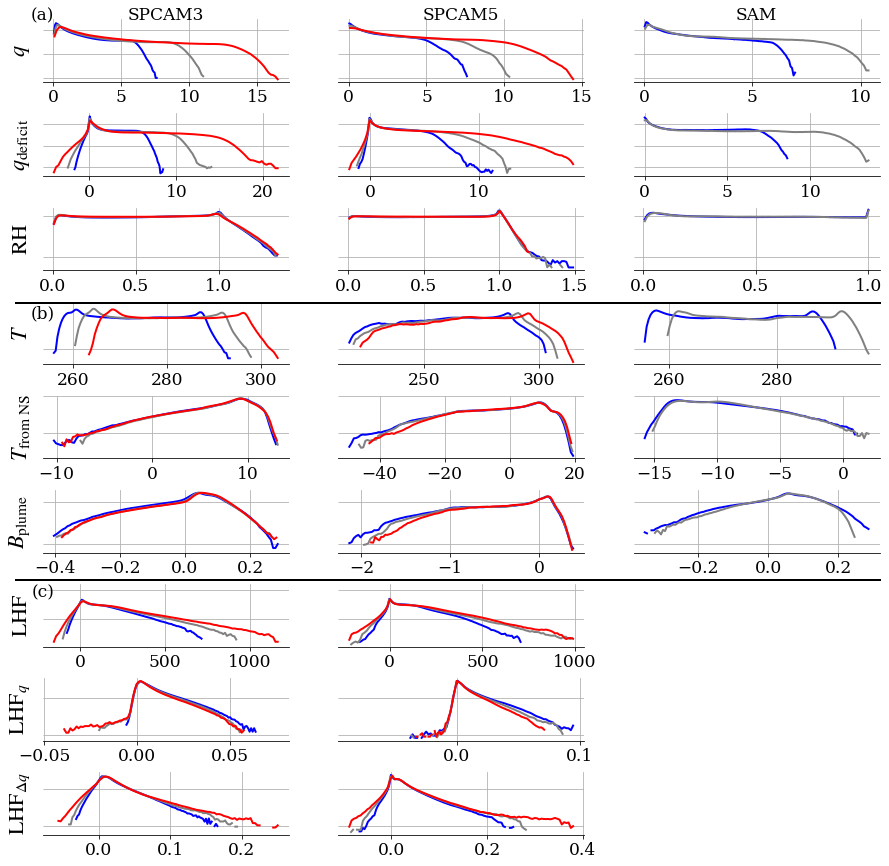

In [380]:
fig,ax = plt.subplots(9,3,figsize=(15,15))

warnings.filterwarnings("ignore") # We are taking the log of zero to facilitate visualization of certain PDFs

for ivar in range(3):
    if ivar==0: VARarray = ['QV','QfromQsat','RH']; edg = edgQ; his = hisQ;
    elif ivar==1: VARarray = ['T','TfromNS','BMSE']; edg = edgT; his = hisT;
    elif ivar==2: VARarray = ['LHF','LHF_nsQ','LHF_nsDELQ']; edg = edgLHF; his  = hisLHF;
    print('ivar=',ivar,'VARarray=',VARarray)
        
    for iconfig in range(3):
        if iconfig==0: path0 = path_aqua
        elif iconfig==1: path0 = path_RG
        elif iconfig==2: path0 = path_SAM

        for ipath,path in enumerate(path0):
            for iresc,resc in enumerate(VARarray):
                
                if iconfig==2 and ivar==2:
                    if ipath==0:
                        fig.delaxes(ax[3*ivar+iresc,iconfig]);
                else:
                    if plot_log[ivar]: toplot = np.log10(his[resc][path])
                    else: toplot = his[resc][path]

                    ax[3*ivar+iresc,iconfig].plot(edg2bin(edg[resc][path]),
                                                  toplot,
                                                  color=color_array[ipath])
    
        # Additionally plot 150hPa temperature rescalings for temperature plots
#         if ivar==1:
#             for ipath,path in enumerate(path0):
#                 for iresc,resc in enumerate(VARarray):

#                     if plot_log[ivar]: toplot = np.log10(hisT150[resc][path])
#                     else: toplot = hisT150[resc][path]

#                     ax[3*ivar+iresc,iconfig].plot(edg2bin(edgT150[resc][path]),
#                                                   toplot,
#                                                   color=color_array[ipath],
#                                                   linestyle='--')        

    plt.draw()

    for iresc,resc in enumerate(VARarray):
        YLIM_MIN = 1e9; YLIM_MAX = 0 # Initialization
        for iconfig in range(3):
            YLIM = ax[3*ivar+iresc,iconfig].get_ylim()
            YLIM_MIN = np.minimum(YLIM_MIN,YLIM[0])
            YLIM_MAX = np.maximum(YLIM_MAX,YLIM[1])
        for iconfig in range(3):
            ax[3*ivar+iresc,iconfig].set_ylim((YLIM_MIN,YLIM_MAX))
            ax[3*ivar+iresc,iconfig].grid()
            ax[3*ivar+iresc,iconfig].yaxis.set_major_formatter(NullFormatter())
            ax[3*ivar+iresc,iconfig].tick_params(axis='y', colors='white')
            for ipos,pos in enumerate(['top','right','left']):
                ax[3*ivar+iresc,iconfig].spines[pos].set_visible(False)
            
            if iconfig==0: ax[3*ivar+iresc,iconfig].set_ylabel(YLAB[ivar][resc],fontsize=1.3*fz)
                
plt.subplots_adjust(hspace=0.5)
#fig.tight_layout()
# Title of each column and letters of each panel
for iconfig in range(3):
    ax[0][iconfig].text(0.5,Y0[0],TITLE[iconfig],va='top',ha = 'center',
                        transform = ax[0][iconfig].transAxes,fontsize=fz)

for ivar in range(3):
    ax[3*ivar][0].text(0,Y0[ivar],PANEL[ivar],va='top',ha = 'center',
                       transform = ax[3*ivar][0].transAxes,fontsize=fz)

# Draw separators between three variables
# Adapted from [https://stackoverflow.com/questions/26084231/draw-a-separator-or-lines-between-subplots]
# rearange the axes for no overlap

# Get the bounding boxes of the axes including text decorations
r = fig.canvas.get_renderer()
get_bbox = lambda ax: ax.get_tightbbox(r).transformed(fig.transFigure.inverted())
bboxes = np.array(list(map(get_bbox, ax.flat)), mtrans.Bbox).reshape(ax.shape)

#Get the minimum and maximum extent, get the coordinate half-way between those
ymax = np.array(list(map(lambda b: b.y1, bboxes.flat))).reshape(ax.shape).max(axis=1)
ymin = np.array(list(map(lambda b: b.y0, bboxes.flat))).reshape(ax.shape).min(axis=1)
ys = np.c_[ymax[1:], ymin[:-1]].mean(axis=1)

# Draw a horizontal lines at those coordinates
for y in ys[[2,5]]:
    line = plt.Line2D([0.1,0.9],[y-delY,y-delY], transform=fig.transFigure, color="black")
    fig.add_artist(line)

plt.savefig(path_Fig+'Fig4.pdf', format='pdf')

# Fig 5

## Load data

In [159]:
hf = open(path_Fig+'SPCAM3_MSE_Progressive_Rescaling.pkl','rb')
MSEp = pickle.load(hf)
hf.close()

In [163]:
MSE_gen = MSEp['MSE_gen']

In [167]:
coor = xr.open_dataset(path_Fig+'Sample_SPCAM3_p0K.nc')

## Plot MSE profiles

In [168]:
path_array = [
    '2021_04_26_NN.hdf5','2021_06_13_NN_RH.hdf5',
    '2021_06_21_NN_RH_BMSE.hdf5',
    '2021_06_17_NN_RH_BMSE_LHF_nsDELQ.hdf5',
    '2021_04_27_W2C_NN.hdf5',
]
LAB = ['BF (-4K)','$\\tilde{q}$','$\\tilde{q},\\tilde{T}$',
       '$\\tilde{q},\\tilde{T},\\tilde{\\mathrm{LHF}}}$',
       'BF (+4K)','','','']
LAB2 = ['','','','','BF (+4K)','','','']
XLAB = ['$\\dot{q}$','$\\dot{T}$','$\\dot{q}$','$\\dot{q}$ (Zoom)',
        '$\\dot{T}$','$\\dot{T}$ (Zoom)','lw','sw','lw','lw (Zoom)',
        'sw','sw (Zoom)']
YLAB = 'Pressure [hPa]'

fz = 15
lw = 2
siz = 50
TITa = '(a) MSE in Cold Tropics [10$^{3}$ W$^{2}$ m$^{-4}$]'
TITb = '(b) '+r'$\bf{Generalization}$'+' Test: MSE in Warm Tropics [10$^{3}$ W$^{2}$ m$^{-4}$]'
Y0 = 1.1

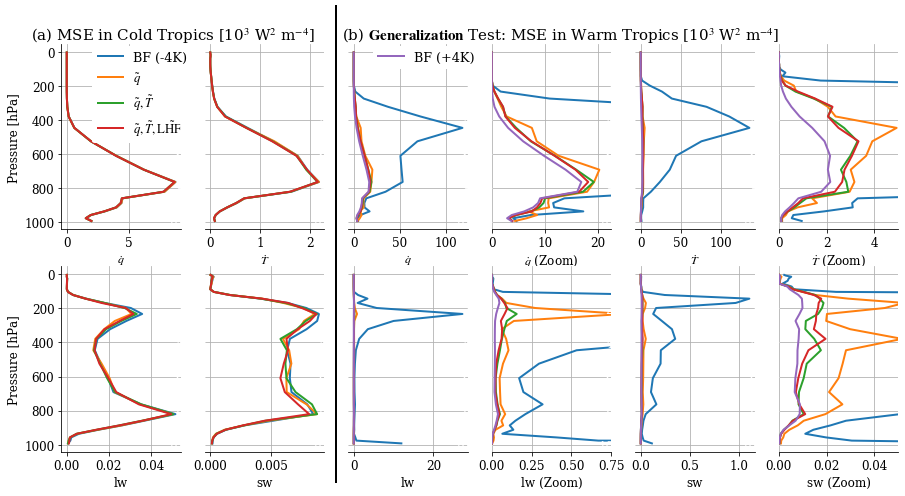

In [177]:
fig, ax = plt.subplots(2,6,figsize=(15,7.5))

for isub in range(12):
    ilin = int(np.floor(isub/6))
    icol = isub-6*ilin
    if icol<2: ilim=4;
    else: ilim=5; # Do not depict reference BF (+4K) in cold climates
    for ipath,path in enumerate(path_array[:ilim]):

        if isub==0: toplot = np.mean(MSE_gen['AQ-4K'][path][:30,:],axis=1)/1e3
        elif isub==1: toplot = np.mean(MSE_gen['AQ-4K'][path][30:60,:],axis=1)/1e3
        elif isub==2 or isub==3: toplot = np.mean(MSE_gen['AQ+4K'][path][:30,:],axis=1)/1e3
        elif isub==4 or isub==5: toplot = np.mean(MSE_gen['AQ+4K'][path][30:60,:],axis=1)/1e3
        elif isub==6: toplot = np.mean(MSE_gen['AQ-4K'][path][60:90,:],axis=1)/1e3
        elif isub==7: toplot = np.mean(MSE_gen['AQ-4K'][path][90:120,:],axis=1)/1e3
        elif isub==8 or isub==9: toplot = np.mean(MSE_gen['AQ+4K'][path][60:90,:],axis=1)/1e3
        elif isub==10 or isub==11: toplot = np.mean(MSE_gen['AQ+4K'][path][90:120,:],axis=1)/1e3
        
        if isub==0: ax[ilin,icol].plot(toplot,coor.lev,label=LAB[ipath])
        elif isub==2: ax[ilin,icol].plot(toplot,coor.lev,label=LAB2[ipath])
        else: ax[ilin,icol].plot(toplot,coor.lev)

    if isub==0: 
        leg = ax[0,0].legend(loc='upper right',fontsize=0.85*fz,
                           frameon=True,facecolor='white', framealpha=1,
                           bbox_to_anchor=(1.15,1.025))
        leg.get_frame().set_linewidth(0.0)
    elif isub==2:
        leg = ax[0,2].legend(loc='upper right',fontsize=0.85*fz,
                           frameon=True,facecolor='white', framealpha=1,
                           bbox_to_anchor=(1.15,1.025))
        leg.get_frame().set_linewidth(0.0)
    
    ax[ilin,icol].invert_yaxis(); ax[ilin,icol].grid()
    ax[ilin,icol].set_xlabel(XLAB[isub])
    if isub==0 or isub==6: ax[ilin,icol].set_ylabel(YLAB)
    else: 
        ax[ilin,icol].spines['left'].set_visible(False)
        ax[ilin,icol].tick_params(axis='y', colors='white')

    for ipos,pos in enumerate(['right','top']):
        ax[ilin,icol].spines[pos].set_visible(False)

    if isub==3: ax[ilin,icol].set_xlim((0,22.5))
    elif isub==5: ax[ilin,icol].set_xlim((0,5))
    elif isub==9: ax[ilin,icol].set_xlim((0,0.75))
    elif isub==11: ax[ilin,icol].set_xlim((0,0.05))

plt.draw()
ax[0,0].text(-0.25,Y0,TITa,va='top',ha ='left',transform = ax[0,0].transAxes,fontsize=fz);
ax[0,2].text(2.35,Y0,TITb,va='top',ha ='left',transform = ax[0,0].transAxes,fontsize=fz);

xs = 0.5*(ax[0,1].get_position().x1+ax[0,2].get_position().x0)
line = plt.Line2D([xs,xs],[0.07,0.95], transform=fig.transFigure, color="black")
fig.add_artist(line)

plt.savefig(path_Fig+'Fig5.pdf', format='pdf')

# Fig 6

## Load data

In [ ]:
STaqua_m4K = xr.open_dataset(path_Fig+'Sample_SPCAM3_m4K.nc')
STaqua_0K = xr.open_dataset(path_Fig+'Sample_SPCAM3_p0K.nc')
STaqua_p4K = xr.open_dataset(path_Fig+'Sample_SPCAM3_p4K.nc')

ST_m4K = xr.open_dataset(path_Fig+'Sample_SPCAM5_m4K.nc')
ST_0K = xr.open_dataset(path_Fig+'Sample_SPCAM5_p0K.nc')
ST_p4K = xr.open_dataset(path_Fig+'Sample_SPCAM5_p4K.nc')

In [185]:
hf = open(path_Fig+'SPCAM_R2_dT500.pkl','rb')
R2_SPCAM = pickle.load(hf)
hf.close()
R2_SPCAM = R2_SPCAM['R2_SH_geo']

In [186]:
hf = open(path_Fig+'SAM_R2_dT500.pkl','rb')
R2_Janni = pickle.load(hf)
hf.close()

In [187]:
hf = open(path_Fig+'SAM_coordinates.pkl','rb')
coor_Janni = pickle.load(hf)
hf.close()

## Make figure

In [188]:
vmin0 = -1
vmax0 = 1

Possibility of Combining two colormaps using [https://stackoverflow.com/questions/31051488/combining-two-matplotlib-colormaps]

In [182]:
# Create custom colormap following [https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar]
cmap = plb.cm.viridis
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap_R2 = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = np.linspace(vmin0, vmax0, 9)
norm_R2 = mpl.colors.BoundaryNorm(bounds, cmap.N)

In [194]:
CBAR_position = [0.87, 0.25, 0.015, 0.5]
Y0 = 1.5; # Position of the text above the subplots
Titles = ['SPCAM3','SPCAM5','SAM']

In [195]:
fz = 12
lw = 4
siz = 100

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw

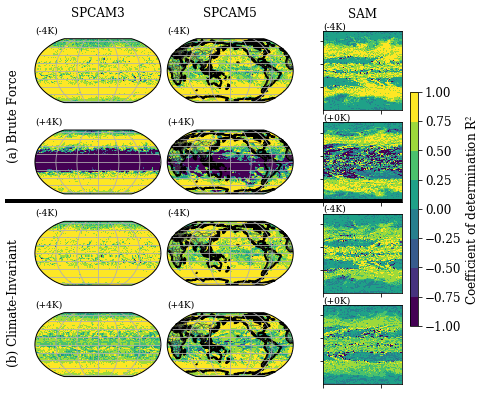

In [206]:
fig, ax = plt.subplots(4,3,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)},figsize=(7,6.5))

for isub in range(12):
    ilin = int(np.floor(isub/3))
    icol = isub-3*ilin
    
    if ilin%2==0: 
        tit = '(-4K)'; 
        if icol==0: dataset = 'AQ-4K'; data = STaqua_m4K
        elif icol==1: dataset = 'RG-4K'; data = ST_m4K
    else: 
        tit = '(+4K)'
        if icol==0: dataset = 'AQ+4K'; data = STaqua_p4K
        elif icol==1: dataset = 'RG+4K'; data = ST_p4K
        
    if isub==0 or isub==3: toplot = R2_SPCAM[dataset]['2021_04_26_NN.hdf5']
    elif isub==1 or isub==4: toplot = R2_SPCAM[dataset]['2021_06_03_RG2AQ_NN.hdf5']
    elif isub==6 or isub==9: toplot = R2_SPCAM[dataset]['2021_04_26_NN_RH_TfromNS_LHF_nsDELQ.hdf5']
    elif isub==7 or isub==10: toplot =  R2_SPCAM[dataset]['2021_06_17_RG2AQ_NN_RH_BMSE_LHF_nsDELQ.hdf5']
    else: toplot = -toplot**0
    #print('isub = ',isub,'and mean R2 is ',np.mean(toplot.flatten()))
    imag = ax[ilin][icol].pcolormesh(data.lon, data.lat, 
                                     toplot,cmap=cmap_R2, norm=norm_R2,
                                     transform=ccrs.PlateCarree(),
                                     vmin=-1,vmax=1)
    ax[ilin][icol].gridlines()
    
    if icol%3==2: 
        ax[ilin][icol].remove()
        ax[ilin][icol] = fig.add_subplot(4,3,3*ilin+icol+1)
        if isub==2: toplot = R2_Janni['No_Climate_invar']['qobs']['Tout_lev15']; tit = '(-4K)'
        elif isub==5: toplot = R2_Janni['No_Climate_invar']['qobs4K']['Tout_lev15']; tit = '(+0K)'
        elif isub==8: toplot = R2_Janni['Climate_invar']['qobs']['Tout_lev15']; tit = '(-4K)'
        elif isub==11: toplot = R2_Janni['Climate_invar']['qobs4K']['Tout_lev15']; tit = '(+0K)'
        imag = ax[ilin][icol].pcolormesh(coor_Janni['x'],coor_Janni['y'],toplot.T,
                                                 cmap=cmap_R2,norm=norm_R2,
                                                 vmin=-1,vmax=1)
        ax[ilin][icol].set_aspect(0.4)
        ax[ilin][icol].xaxis.set_ticklabels([])
        ax[ilin][icol].yaxis.set_ticklabels([])
    
    
    if icol<2: ax[ilin][icol].set_title(tit,loc='left',fontsize=3*fz/4)
    else: ax[ilin][icol].set_title(tit,loc='left',fontsize=3*fz/4,pad=-0.1)
    if icol==1:
            ax[ilin][icol].coastlines(linewidth=2.0,edgecolor='0.25')
            ax[ilin][icol].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

    # Colorbar
    if isub==0:
        cbar_ax = fig.add_axes(CBAR_position)
        CBAR = fig.colorbar(imag, label="Coefficient of determination R$^{2}$", cax=cbar_ax)
        cbar_ax.yaxis.set_ticks_position('right')
        cbar_ax.yaxis.set_label_position('right')

    # Title of each column
    if ilin==0:
        if isub<3: 
            TEXT[isub] = ax[0][isub].text(0.5,Y0,Titles[isub],fontsize=fz,
                                                   va='top',ha = 'center',
                                                   transform = ax[0][isub].transAxes)
            
plt.draw()
# Horizontal line in the middle
ys = 0.7*ax[1,0].get_position().y0+0.3*ax[2,0].get_position().y1
line = plt.Line2D([0.07,0.85],[ys,ys], transform=fig.transFigure, color="black")
fig.add_artist(line)
# Vertical text to indicate subplots
plt.text(0.07,0.7,'(a) Brute Force',rotation=90,va='center',transform=fig.transFigure, color="black");
plt.text(0.07,0.3,'(b) Climate-Invariant',rotation=90,va='center',transform=fig.transFigure, color="black");

plt.subplots_adjust(wspace=0.05, hspace=0.15)
TEXT[2].set_position((0.5,1.3))

plt.savefig(path_Fig+'Fig6.pdf', format='pdf')

# Fig 7

## Load data

In [3]:
hf = open(path_Fig+'SPCAM_R2_dT.pkl','rb')
R2_SPCAM = pickle.load(hf)
hf.close()
R2_SPCAM = R2_SPCAM['R2_SH_geo']

In [4]:
hf = open(path_Fig+'SAM_R2_dT.pkl','rb')
R2_Janni = pickle.load(hf)
hf.close()

In [5]:
hf = open(path_Fig+'SAM_coordinates.pkl','rb')
coor_Janni = pickle.load(hf)
hf.close()

In [7]:
STaqua_m4K = xr.open_dataset(path_Fig+'Sample_SPCAM3_m4K.nc')
STaqua_0K = xr.open_dataset(path_Fig+'Sample_SPCAM3_p0K.nc')
STaqua_p4K = xr.open_dataset(path_Fig+'Sample_SPCAM3_p4K.nc')

ST_m4K = xr.open_dataset(path_Fig+'Sample_SPCAM5_m4K.nc')
ST_0K = xr.open_dataset(path_Fig+'Sample_SPCAM5_p0K.nc')
ST_p4K = xr.open_dataset(path_Fig+'Sample_SPCAM5_p4K.nc')

## Plot lat-p R2 maps

In [35]:
vmin0 = -1
vmax0 = 1
# Create custom colormap following [https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar]
cmap = plb.cm.viridis
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap_R2 = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = np.linspace(vmin0, vmax0, 9)
norm_R2 = mpl.colors.BoundaryNorm(bounds, cmap.N)

In [52]:
CBAR_position = [0.91, 0.35, 0.01, 0.3]
Y0 = 1.5; # Position of the text above the subplots
Titles = ['SPCAM3','SPCAM5','SAM']

In [76]:
fz = 12
lw = 2
siz = 100

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw

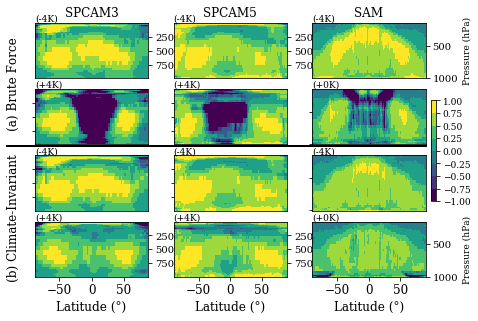

In [77]:
fig, ax = plt.subplots(4,3,figsize=(7,2/3*7))

TEXT = {}

for isub in range(12):
    ilin = int(np.floor(isub/3))
    icol = isub-3*ilin
    
    if ilin%2==0: 
        tit = '(-4K)'; 
        if icol==0: dataset = 'AQ-4K'; data = STaqua_m4K
        elif icol==1: dataset = 'RG-4K'; data = ST_m4K
    else: 
        tit = '(+4K)'
        if icol==0: dataset = 'AQ+4K'; data = STaqua_p4K
        elif icol==1: dataset = 'RG+4K'; data = ST_p4K
        
    if isub==0 or isub==3: toplot = R2_SPCAM[dataset]['2021_04_26_NN.hdf5']
    elif isub==1 or isub==4: toplot = R2_SPCAM[dataset]['2021_06_03_RG2AQ_NN.hdf5']
    elif isub==6 or isub==9: toplot = R2_SPCAM[dataset]['2021_04_26_NN_RH_TfromNS_LHF_nsDELQ.hdf5']
    elif isub==7 or isub==10: toplot =  R2_SPCAM[dataset]['2021_06_17_RG2AQ_NN_RH_BMSE_LHF_nsDELQ.hdf5']
    else: toplot = -toplot**0
    #print('isub = ',isub,'and mean R2 is ',np.mean(toplot.flatten()))
    imag = ax[ilin][icol].pcolormesh(data.lat, data.lev, 
                                     toplot.T,cmap=cmap_R2, norm=norm_R2,
                                     vmin=-1,vmax=1)
    
    if icol%3==2: 
        ax[ilin][icol].remove()
        ax[ilin][icol] = fig.add_subplot(4,3,3*ilin+icol+1)
        if isub==2: toplot = R2_Janni['No_Climate_invar']['qobs']['Tout']; tit = '(-4K)'
        elif isub==5: toplot = R2_Janni['No_Climate_invar']['qobs4K']['Tout']; tit = '(+0K)'
        elif isub==8: toplot = R2_Janni['Climate_invar']['qobs']['Tout']; tit = '(-4K)'
        elif isub==11: toplot = R2_Janni['Climate_invar']['qobs4K']['Tout']; tit = '(+0K)'
        yJ = coor_Janni['y']
        imag = ax[ilin][icol].pcolormesh(180*((yJ-yJ.min())/(yJ.max()-yJ.min())-0.5),
                                         coor_Janni['p'][:30],toplot.T,
                                         cmap=cmap_R2,norm=norm_R2,
                                         vmin=-1,vmax=1)
    
    if ilin<3: 
        ax[ilin][icol].xaxis.set_ticklabels([])
        ax[ilin][icol].set_xticks([])
    else: ax[ilin][icol].set_xlabel('Latitude (°)')
    if ilin==1 or ilin==2: ax[ilin][icol].yaxis.set_ticklabels([])
    else: 
        ax[ilin][icol].yaxis.tick_right()
        ax[ilin][icol].tick_params(axis='y', which='major', labelsize=10)
        if icol==2:
            ax[ilin][icol].yaxis.set_label_position("right")
            ax[ilin][icol].set_ylabel('Pressure (hPa)',fontsize=0.75*fz)
    
    ax[ilin][icol].set_title(tit,loc='left',fontsize=3*fz/4,pad=-10)
    ax[ilin][icol].invert_yaxis()

    # Colorbar
    if isub==0:
        cbar_ax = fig.add_axes(CBAR_position)
        #CBAR = fig.colorbar(imag, label="Coef. of determination R$^{2}$", cax=cbar_ax)
        CBAR = fig.colorbar(imag, cax=cbar_ax)
        cbar_ax.yaxis.set_ticks_position('right')
        cbar_ax.yaxis.set_label_position('right')
        cbar_ax.tick_params(labelsize=0.75*fz)

    # Title of each column
    if ilin==0:
        if isub<3: 
            TEXT[isub] = ax[0][isub].text(0.5,Y0,Titles[isub],fontsize=fz,
                                                   va='top',ha = 'center',
                                                   transform = ax[0][isub].transAxes)
            
plt.draw()
# Horizontal line in the middle
ys = 0.85*ax[1,0].get_position().y0+0.15*ax[2,0].get_position().y1
line = plt.Line2D([0.07,0.9],[ys,ys], 
                  transform=fig.transFigure, color="black")
fig.add_artist(line)
# Vertical text to indicate subplots
plt.text(0.07,0.7,'(a) Brute Force',rotation=90,va='center',
         transform=fig.transFigure, color="black",fontsize=fz);
plt.text(0.07,0.3,'(b) Climate-Invariant',rotation=90,va='center',
         transform=fig.transFigure, color="black",fontsize=fz);

#plt.subplots_adjust(left=-1e-3,wspace=0.05, hspace=0.15)
plt.subplots_adjust(wspace=0.225)
for i in range(3):
    TEXT[i].set_position((0.5,1.3))

plt.savefig(path_Fig+'Fig7.pdf', format='pdf')

# Fig 8

## Load data

In [28]:
hf = open(path_Fig+'SPCAM3_SHAP_Matrix.pkl','rb')
SHAP_toplot = pickle.load(hf)
hf.close()

SHAP_toplot = SHAP_toplot['SHAP_toplot']

## Only plot the convective heating and moistening response to T and q

In [29]:
# For outputs
XTEXT = 63
YTEXT = 17
# For inputs
XINP = 17
YINP2 = 64
# For titles
YTIT = -5
# For colorbar
CBAR_position = [0.72, 0.25, 0.015, 0.5]
VMIN = -10; VMAX = 10

fac_conf = 1 # Multiplicative factor for conferences (set to 1 for paper, 4 for conferences)

fz = fac_conf*20
lw = (fac_conf**0.5)*6
siz = 250

In [30]:
plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

In [31]:
S = SHAP_toplot
fac_conf = 1

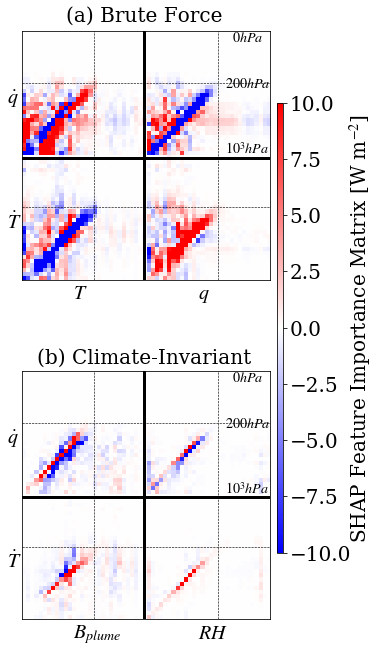

In [32]:
fig,ax = plt.subplots(2,1,figsize=(5,12.5))

for ilin in range(2):

    if ilin==0: 
        toplot = S['2021_04_27_W2C_NN.hdf5'][:60,:60].T
    elif ilin==1: 
        toplot = (S['2021_06_17_W2C_NN_RH_BMSE_LHF_nsDELQ.hdf5'][:60,:60].T)
    
    mapp = ax[ilin].imshow(toplot,cmap='bwr',vmin=VMIN,vmax=VMAX)
    ax[ilin].invert_xaxis()
    ax[ilin].axvline(x=30,color='k',linewidth=lw/2)
    ax[ilin].axvline(x=12,color='k',linewidth=lw/10,linestyle='--')
    ax[ilin].axvline(x=42,color='k',linewidth=lw/10,linestyle='--')
    for ix,xline in enumerate([30]):
        ax[ilin].axhline(y=xline,color='k',linewidth=lw/2)
    for ix,xline in enumerate([12,42]):
        ax[ilin].axhline(y=xline,color='k',linewidth=lw/10,linestyle='--')
    ax[ilin].set_xticks([])
    ax[ilin].set_yticks([])

    # Colorbar
    if ilin==0:
        cbar_ax = fig.add_axes(CBAR_position)
        CBAR = fig.colorbar(mapp,cax=cbar_ax)
        CBAR.set_label("SHAP Feature Importance Matrix [W m$^{-2}$]", labelpad=-3)
        cbar_ax.yaxis.set_ticks_position('right')
        cbar_ax.yaxis.set_label_position('right')

    # Output text
    ax[ilin].text(XTEXT,YTEXT,'$\dot{q}$')
    ax[ilin].text(XTEXT,30+YTEXT,'$\dot{T}$')
    
    # Vertical coordinate
    ax[ilin].text(5,2,'$0hPa$',fontsize=0.7*fz,ha='center')
    ax[ilin].text(5,13,'$200hPa$',fontsize=0.7*fz,ha='center')
    ax[ilin].text(5,29,'$10^{3}hPa$',fontsize=0.7*fz,ha='center')
    
    # Input text
    if ilin==0:
        ax[ilin].text(XINP,YINP2,'$q$')
        ax[ilin].text(XINP+30,YINP2,'$T$')
    elif ilin==1:
        ax[ilin].text(XINP,YINP2,'$RH$')
        ax[ilin].text(XINP+30,YINP2,'$B_{plume}$')
        
plt.subplots_adjust(left=0.01, bottom=None, right=0.7, top=None, wspace=None, hspace=0)

plt.draw()

# Vertical text to indicate subplots
plt.text(0.35,0.84,'(a) Brute Force',ha='center',transform=fig.transFigure, color="black");
plt.text(0.35,0.46,'(b) Climate-Invariant',ha='center',transform=fig.transFigure, color="black");

plt.savefig(path_Fig+'Fig8.pdf', format='pdf')

# Fig S1

## Load data

In [157]:
hf = open(path_Fig+'SPCAM_SHF_ps_histogram.pkl','rb')
SHF_ps_data = pickle.load(hf)
hf.close()

In [158]:
his = SHF_ps_data['hisSM']
edg = SHF_ps_data['edgSM']

In [159]:
path_aqua = [
     '2021_03_18_O3_TRAIN_M4K_shuffle.nc',
     '2021_01_24_O3_TRAIN_shuffle.nc',
     '2021_03_18_O3_TRAIN_P4K_shuffle.nc'
]
path_RG = [
    '2021_04_18_RG_TRAIN_M4K_shuffle.nc',
    '2021_06_03_RG_TRAIN_shuffle.nc',
    '2021_04_18_RG_TRAIN_P4K_shuffle.nc'
]
color_array = ['b','gray','red']

In [160]:
def edg2bin(bin_edges):
    return 0.5*(bin_edges[1:]+bin_edges[:-1])

## Plot PDFs in SPCAM case

In [161]:
fz = 12
lw = 2
siz = 100

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw

TITLE = ["Aquaplanet (SPCAM3)","Earth-like (SPCAM5)"]
Y0 = 1.2

plot_log = [True,True]

In [162]:
YLAB = {}

YLAB[0] = {}
YLAB[0]['SHF'] = '$\\mathrm{SHF}\\ \\left[\\mathrm{W\\ m^{-2}}\\right]$'

YLAB[1] = {}
YLAB[1]['ps'] = '$p_{s}\\ \\left[\\mathrm{hPa}\\right]$'

ivar= 0 VARarray= ['SHF']
ivar= 1 VARarray= ['ps']


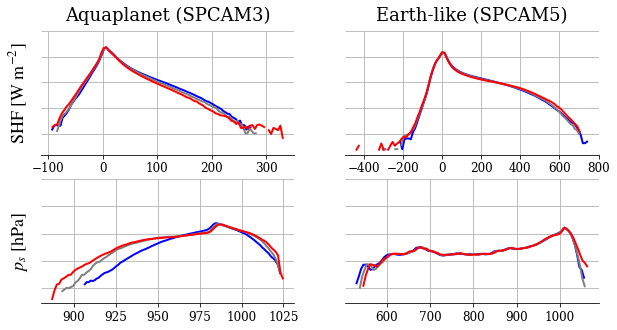

In [163]:
fig,ax = plt.subplots(2,2,figsize=(10,5))

warnings.filterwarnings("ignore") # We are taking the log of zero to facilitate visualization of certain PDFs

for ivar in range(2):
    if ivar==0: VARarray = ['SHF']; scaling = 1;
    elif ivar==1: VARarray = ['ps']; scaling = 1e2; # Conversion from Pa to hPa
    print('ivar=',ivar,'VARarray=',VARarray)
        
    for iconfig in range(2):
        if iconfig==0: path0 = path_aqua
        elif iconfig==1: path0 = path_RG

        for ipath,path in enumerate(path0):
            for iresc,resc in enumerate(VARarray):
                
                if plot_log[ivar]: toplot = np.log10(his[resc][path])
                else: toplot = his[resc][path]
                
                ax[ivar+iresc,iconfig].plot(edg2bin(edg[resc][path])/scaling,
                                              toplot,color=color_array[ipath])

    plt.draw()

    for iresc,resc in enumerate(VARarray):
        YLIM_MIN = 1e9; YLIM_MAX = 0 # Initialization
        for iconfig in range(2):
            YLIM = ax[ivar+iresc,iconfig].get_ylim()
            YLIM_MIN = np.minimum(YLIM_MIN,YLIM[0])
            YLIM_MAX = np.maximum(YLIM_MAX,YLIM[1])
        for iconfig in range(2):
            ax[ivar+iresc,iconfig].set_ylim((YLIM_MIN,YLIM_MAX))
            ax[ivar+iresc,iconfig].grid()
            ax[ivar+iresc,iconfig].yaxis.set_major_formatter(NullFormatter())
            ax[ivar+iresc,iconfig].tick_params(axis='y', colors='white')
            for ipos,pos in enumerate(['top','right','left']):
                ax[ivar+iresc,iconfig].spines[pos].set_visible(False)
            
            if iconfig==0: ax[ivar+iresc,iconfig].set_ylabel(YLAB[ivar][resc],fontsize=1.5*fz)
                
# Title of each column and letters of each panel
for iconfig in range(2):
    ax[0][iconfig].text(0.5,Y0,TITLE[iconfig],va='top',ha = 'center',
                        transform = ax[0][iconfig].transAxes,fontsize=1.5*fz)
    
plt.savefig(path_Fig+'FigS1.pdf', format='pdf')

# Fig S3

## Load data

In [198]:
hf = open(path_Fig+'SPCAM_R2_Output_Rescaling.pkl','rb')
R2_map = pickle.load(hf)
R2_map = R2_map['R2_map']
hf.close()

In [199]:
coor = xr.open_dataset(path_Fig+'Sample_SPCAM3_m4K.nc')

## Make figure

In [200]:
vmin0 = -1
vmax0 = 1
# Create custom colormap following [https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar]
cmap = plb.cm.viridis
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap_R2 = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = np.linspace(vmin0, vmax0, 9)
norm_R2 = mpl.colors.BoundaryNorm(bounds, cmap.N)

In [204]:
CBAR_position = [0.77, 0.25, 0.02, 0.5]
LABEL = ['(a) Brute Force','(b) Climate Invariant','(c) Cl.Inv.+QM after','(d) Cl.Inv.+QM before']

In [205]:
fz = 12
lw = 4
siz = 100

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

itype= 0  & modeltype= BF
itype= 1  & modeltype= I
itype= 2  & modeltype= IQM
itype= 3  & modeltype= IO


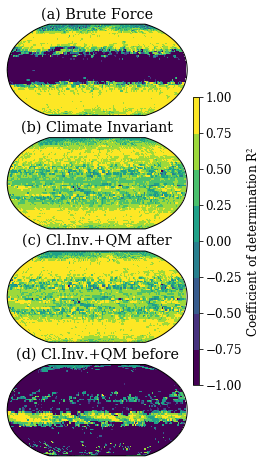

In [206]:
fig, ax = plt.subplots(4,1,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)},figsize=(4,8))

for itype,modeltype in enumerate(['BF','I','IQM','IO']):
    print ('itype=',itype,' & modeltype=',modeltype)
    toplot = R2_map['AQ+4K'][modeltype]
    imag = ax[itype].pcolormesh(coor.lon,coor.lat,toplot,cmap = cmap_R2, norm = norm_R2, transform=ccrs.PlateCarree())
    ax[itype].set_title(LABEL[itype])
    
    # Colorbar
    if itype==0:
        cbar_ax = fig.add_axes(CBAR_position)
        CBAR = fig.colorbar(imag, label="Coefficient of determination R$^{2}$", cax=cbar_ax)
        cbar_ax.yaxis.set_ticks_position('right')
        cbar_ax.yaxis.set_label_position('right')

plt.subplots_adjust(right=0.75)
plt.savefig(path_Fig+'FigS3.pdf', format='pdf')

# Fig S5

## Load data

### Trained on SPCAM3 (-4K)

In [234]:
hf = open(path_Fig+'SPCAM_Learning_Curve_MLR_BF.pkl','rb')
hist_MLR_BF = pickle.load(hf)
hist_MLR_BF = hist_MLR_BF['hist']
hf.close()

In [235]:
path_NN_BF1 = path_Fig + 'SPCAM_Learning_Curve_NN_BF1.pkl'
path_NN_BF2 = path_Fig + 'SPCAM_Learning_Curve_NN_BF2.pkl'

hf = open(path_NN_BF1,'rb')
hist_NN_BF1 = pickle.load(hf)
hist_NN_BF1 = hist_NN_BF1['hist']
hf.close()

hf = open(path_NN_BF2,'rb')
hist_NN_BF2 = pickle.load(hf)
hist_NN_BF2 = hist_NN_BF2['hist']
hf.close()

hist_NN_BF = {}
for ikey,key in enumerate(hist_NN_BF1.keys()):
    hist_NN_BF[key] = 0.5*(np.array(hist_NN_BF1[key])+np.array(hist_NN_BF2[key]))

In [236]:
path_MLR_BMSE = path_Fig + 'SPCAM_Learning_Curve_MLR_CI.pkl'
hf = open(path_MLR_BMSE,'rb')
hist_MLR_BMSE = pickle.load(hf)
hist_MLR_BMSE = hist_MLR_BMSE['hist']
hf.close()

In [237]:
path_NN_BMSE = path_Fig + 'SPCAM_Learning_Curve_NN_CI.pkl'
hf = open(path_NN_BMSE,'rb')
hist_NN_BMSE = pickle.load(hf)
hist_NN_BMSE = hist_NN_BMSE['hist']
hf.close()

### Trained on SPCAM3 (+4K)

In [238]:
path_MLR_BF_W2C = path_Fig + 'SPCAM_Learning_Curve_p4K_MLR_BF.pkl'
hf = open(path_MLR_BF_W2C,'rb')
hist_MLR_BF_W2C = pickle.load(hf)
hist_MLR_BF_W2C = hist_MLR_BF_W2C['hist']
hf.close()

path_NN_BF_W2C = path_Fig + 'SPCAM_Learning_Curve_p4K_NN_BF.pkl'
hf = open(path_NN_BF_W2C,'rb')
hist_NN_BF_W2C = pickle.load(hf)
hist_NN_BF_W2C = hist_NN_BF_W2C['hist']
hf.close()

path_MLR_BMSE_W2C = path_Fig + 'SPCAM_Learning_Curve_p4K_MLR_CI.pkl'
hf = open(path_MLR_BMSE_W2C,'rb')
hist_MLR_BMSE_W2C = pickle.load(hf)
hist_MLR_BMSE_W2C = hist_MLR_BMSE_W2C['hist']
hf.close()

path_NN_BMSE_W2C = path_Fig + 'SPCAM_Learning_Curve_p4K_NN_CI.pkl'
hf = open(path_NN_BMSE_W2C,'rb')
hist_NN_BMSE_W2C = pickle.load(hf)
hist_NN_BMSE_W2C = hist_NN_BMSE_W2C['hist']
hf.close()

### Trained on SPCAM5 (-4K)

In [239]:
path_MLR_BF_RG2AQ = path_Fig + 'SPCAM_Learning_Curve_SPCAM5_MLR_BF.pkl'
hf = open(path_MLR_BF_RG2AQ,'rb')
hist_MLR_BF_RG2AQ = pickle.load(hf)
hist_MLR_BF_RG2AQ = hist_MLR_BF_RG2AQ['hist']
hf.close()

path_NN_BF_RG2AQ = path_Fig + 'SPCAM_Learning_Curve_SCPAM5_NN_BF.pkl'
hf = open(path_NN_BF_RG2AQ,'rb')
hist_NN_BF_RG2AQ = pickle.load(hf)
hist_NN_BF_RG2AQ = hist_NN_BF_RG2AQ['hist']
hf.close()

path_MLR_BMSE_RG2AQ = path_Fig + 'SPCAM_Learning_Curve_SPCAM5_MLR_CI.pkl'
hf = open(path_MLR_BMSE_RG2AQ,'rb')
hist_MLR_BMSE_RG2AQ = pickle.load(hf)
hist_MLR_BMSE_RG2AQ = hist_MLR_BMSE_RG2AQ['hist']
hf.close()

path_NN_BMSE_RG2AQ = path_Fig + 'SPCAM_Learning_Curve_SPCAM5_NN_CI.pkl'
hf = open(path_NN_BMSE_RG2AQ,'rb')
hist_NN_BMSE_RG2AQ = pickle.load(hf)
hist_NN_BMSE_RG2AQ = hist_NN_BMSE_RG2AQ['hist']
hf.close()

### Combining dropout and climate invariant rescaling

In [240]:
path_NN_BNDP = path_Fig + 'SPCAM_Learning_Curve_BNDP_CI.pkl'
hf = open(path_NN_BNDP,'rb')
hist_NN_BNDP = pickle.load(hf)
hist_NN_BNDP = hist_NN_BNDP['hist']
hf.close()

path_NN_BNDP_W2C = path_Fig + 'SPCAM_Learning_Curve_p4K_BNDP_CI.pkl'
hf = open(path_NN_BNDP_W2C,'rb')
hist_NN_BNDP_W2C = pickle.load(hf)
hist_NN_BNDP_W2C = hist_NN_BNDP_W2C['hist']
hf.close()

path_NN_BNDP_RG2AQ = path_Fig + 'SPCAM_Learning_Curve_SPCAM5_BNDP_CI.pkl'
hf = open(path_NN_BNDP_RG2AQ,'rb')
hist_NN_BNDP_RG2AQ = pickle.load(hf)
hist_NN_BNDP_RG2AQ = hist_NN_BNDP_RG2AQ['hist']
hf.close()

## Plot all training curves together

In [241]:
fz = 15
lw = 2
siz = 75

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw

In [242]:
X0 = -0.175; # Position of the y labels
Y0 = 1.025; # Position of the text above the subplots

In [243]:
epoch = np.arange(1,21)

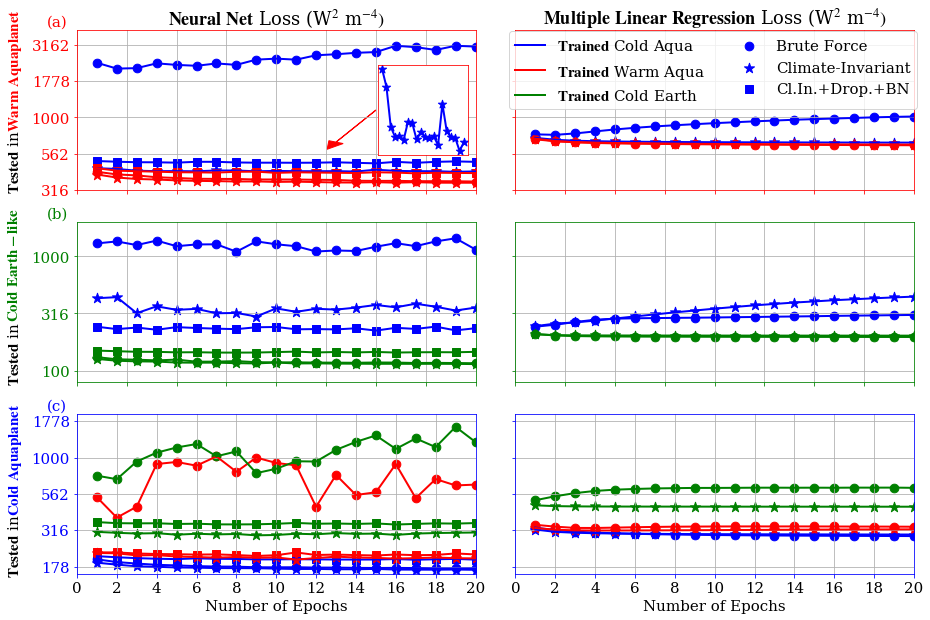

In [244]:
fig, ax = plt.subplots(3,2,figsize=(15,10))
fig.subplots_adjust(hspace=0.2)
fig.subplots_adjust(wspace=0.1)

for isub in range(6):
    ico = int(np.floor(isub/3))
    ili = int(isub-3*np.floor(isub/3))
    
    if ico==1:
        hBF = hist_MLR_BF
        hCI = hist_MLR_BMSE
        hBF_W2C = hist_MLR_BF_W2C
        hCI_W2C = hist_MLR_BMSE_W2C
        hBF_RG2AQ = hist_MLR_BF_RG2AQ
        hCI_RG2AQ = hist_MLR_BMSE_RG2AQ
        LIN = 0; LOG = 1;
    elif ico==0:
        hBF = hist_NN_BF
        hCI = hist_NN_BMSE
        hBN = hist_NN_BNDP
        hBF_W2C = hist_NN_BF_W2C
        hCI_W2C = hist_NN_BMSE_W2C
        hBN_W2C = hist_NN_BNDP_W2C
        hBF_RG2AQ = hist_NN_BF_RG2AQ
        hCI_RG2AQ = hist_NN_BMSE_RG2AQ
        hBN_RG2AQ = hist_NN_BNDP_RG2AQ
        LIN = 0; LOG = 1;
    if ili==2:
        k = 'val_loss'
        kW2C = 'trainM4K_loss'
        kRG2AQ = kW2C
    elif ili==0:
        k = 'trainP4K_loss'
        kW2C = 'val_loss'
        kRG2AQ = 'trainP4K_RG_loss'
    elif ili==1:
        k = 'trainM4K_RG_loss'
        kW2C = 'trainP4K_RG_loss'
        kRG2AQ = 'val_loss'
    
    labC = ''; labW = ''; labE = '';labBF = ''; labCI = ''; labBN = '';
    if ili==2 and ico==0:
        labC = r"$\bf{Trained}$"+' Cold Aqua'
        labW = r"$\bf{Trained}$"+' Warm Aqua'
        labE = r"$\bf{Trained}$"+' Cold Earth'
        labBF = 'Brute Force'
        labCI = 'Climate-Invariant'
        labBN = 'Cl.In.+Drop.+BN'
    
    y = np.array(hBF[k])
    ax[ili,ico].scatter(epoch,LIN*y+LOG*np.log10(y),s=siz,color='b',label=labBF)
    ax[ili,ico].plot(epoch,LIN*y+LOG*np.log10(y),color='b',label=labC)

    y = np.array(hCI[k])
    ax[ili,ico].scatter(epoch,LIN*y+LOG*np.log10(y),s=1.5*siz,color='b',marker='*',label=labCI)
    ax[ili,ico].plot(epoch,LIN*y+LOG*np.log10(y),color='b')
    
    if ico==0: 
        y = np.array(hBN[k])
        ax[ili,ico].scatter(epoch,LIN*y+LOG*np.log10(y),s=siz,color='b',marker='s',label=labBN)
        ax[ili,ico].plot(epoch,LIN*y+LOG*np.log10(y),color='b')
    
    if ili!=1:
    
        y = np.array(hBF_W2C[kW2C])
        ax[ili,ico].scatter(epoch,LIN*y+LOG*np.log10(y),s=siz,color='r')
        ax[ili,ico].plot(epoch,LIN*y+LOG*np.log10(y),color='r',label=labW)

        y = np.array(hCI_W2C[kW2C])
        ax[ili,ico].scatter(epoch,LIN*y+LOG*np.log10(y),s=1.5*siz,color='r',marker='*')
        ax[ili,ico].plot(epoch,LIN*y+LOG*np.log10(y),color='r')
        
        if ico==0: 
            y = np.array(hBN_W2C[kW2C])
            ax[ili,ico].scatter(epoch,LIN*y+LOG*np.log10(y),s=siz,color='r',marker='s')
            ax[ili,ico].plot(epoch,LIN*y+LOG*np.log10(y),color='r')
    
    if ili!=0:
        y = np.array(hBF_RG2AQ[kRG2AQ])
        ax[ili,ico].scatter(epoch,LIN*y+LOG*np.log10(y),s=siz,color='g')
        ax[ili,ico].plot(epoch,LIN*y+LOG*np.log10(y),color='g',label=labE)

        y = np.array(hCI_RG2AQ[kRG2AQ])
        ax[ili,ico].scatter(epoch,LIN*y+LOG*np.log10(y),s=1.5*siz,color='g',marker='*')
        ax[ili,ico].plot(epoch,LIN*y+LOG*np.log10(y),color='g')
        
        if ico==0:
            y = np.array(hBN_RG2AQ[kRG2AQ])
            ax[ili,ico].scatter(epoch,LIN*y+LOG*np.log10(y),s=siz,color='g',marker='s')
            ax[ili,ico].plot(epoch,LIN*y+LOG*np.log10(y),color='g')
    
    plt.draw()
    if ili==2 and ico==0: LEG1 = fig.legend(ncol=2)
    
    if ili==2: 
        ax[ili,ico].set_xlabel('Number of Epochs')
        ax[ili,ico].xaxis.set_major_locator(MaxNLocator(integer=True))
    else: ax[ili,ico].set_xticklabels('')
    if ico==0:
        if ili==2: 
            #ax[ili,ico].set_title(r"$\bf{Tested\ in}$"+r"\textcolor{blue}{a}"+' Cold Aquaplanet (-4K,SPCAM3)',fontsize=fz)
            ax[ili,ico].text(-0.075,Y0,'(c)',fontsize=fz,transform=ax[ili,ico].transAxes,color='blue')
            ax[ili,ico].text(X0,0,r"$\bf{Tested}$"+' in',fontsize=fz,transform=ax[ili,ico].transAxes,
                            rotation='vertical')
            ax[ili,ico].text(X0,0.4, r"$\bf{Cold\ Aquaplanet}$",fontsize=fz,color="blue",
                             transform=ax[ili,ico].transAxes,rotation='vertical')
        elif ili==0: 
            #ax[ili,ico].set_title('Warm Aquaplanet (+4K,SPCAM3)',fontsize=fz)
            ax[ili,ico].text(-0.075,Y0,'(a)',fontsize=fz,transform=ax[ili,ico].transAxes,color='red')
            ax[ili,ico].text(X0,0,r"$\bf{Tested}$"+' in',fontsize=fz,
                             transform=ax[ili,ico].transAxes,rotation='vertical')
            ax[ili,ico].text(X0,0.4, r"$\bf{Warm\ Aquaplanet}$",fontsize=fz,
                             color="red",transform=ax[ili,ico].transAxes,rotation='vertical')
        elif ili==1: 
            #ax[ili,ico].set_title('Cold Earth-like (-4K,SPCAM5)',fontsize=fz)
            ax[ili,ico].text(-0.075,Y0,'(b)',fontsize=fz,transform=ax[ili,ico].transAxes,color='green')
            ax[ili,ico].text(X0,0,r"$\bf{Tested}$"+' in',fontsize=fz,
                             transform=ax[ili,ico].transAxes,rotation='vertical')
            ax[ili,ico].text(X0,0.4, r"$\bf{Cold\ Earth-like}$",fontsize=fz,
                             color="green",transform=ax[ili,ico].transAxes,rotation='vertical')
    if ili==0: 
        if ico==0: ax[ili,ico].set_title(r"$\bf{Neural\ Net}$"+' Loss (W$^{2}$ m$^{-4})$')
        elif ico==1: ax[ili,ico].set_title(r"$\bf{Multiple\ Linear\ Regression}$"+' Loss (W$^{2}$ m$^{-4})$')
    ax[ili,ico].set_xlim((0,20))
    if ili==2: ax[ili,ico].set_ylim((2.2,3.3))
    elif ili==0: ax[ili,ico].set_ylim((2.5,3.6))
    elif ili==1: ax[ili,ico].set_ylim((1.9,3.3))
    ax[ili,ico].grid()
    
    # Add zoom following [https://matplotlib.org/1.3.1/mpl_toolkits/axes_grid/users/overview.html]
    if ili==0 and ico==0:
        axins = inset_axes(ax[ili,ico],width=1.25,height=1.25,
                           loc='center right') # loc = 'center right'
        y = np.array(hCI[k])
        axins.scatter(epoch,y,s=siz,color='b',marker='*')
        axins.plot(epoch,y,color='b')
        #axins.set_ylim((2.6,2.7))
#         y = np.array(hBF_W2C[kW2C])
#         axins.scatter(epoch,LIN*y+LOG*np.log10(y),s=siz/2,color='r')
#         axins.plot(epoch,LIN*y+LOG*np.log10(y),color='r')
#         y = np.array(hCI_W2C[kW2C])
#         axins.scatter(epoch,LIN*y+LOG*np.log10(y),s=siz/2,color='r',marker='*')
#         axins.plot(epoch,LIN*y+LOG*np.log10(y),color='r')
        axins.set_xticks([])
        axins.set_yticks([])
        ax[ili,ico].arrow(0.75,0.5,-0.1,-0.2,
                          color='r',transform=ax[ili,ico].transAxes,
                          head_width=0.04,head_length=0.05)
    
plt.draw()
# Get the bounding box of the original legend
bb = LEG1.get_bbox_to_anchor().inverse_transformed(ax[0,0].transAxes)

# Change to location of the legend. 
xOffset = -0.245
yOffset = -0.5
bb.x0 += xOffset
bb.x1 += xOffset
bb.y0 += yOffset
bb.y1 += yOffset
LEG1.set_bbox_to_anchor(bb, transform = ax[0,0].transAxes)

for ico in range(2):
    for ax0, color in zip([ax[2,ico],ax[0,ico],ax[1,ico],axins], ['blue','red','green','red']):
        plt.setp(ax0.spines.values(), color=color)
        plt.setp([ax0.get_xticklines(), ax0.get_yticklines(),ax0.get_yticklabels()], color=color)

#Change y labels to real value (10^log_value)
for isub in range(6):
    ico = int(np.floor(isub/3))
    ili = int(isub-3*np.floor(isub/3))

    labels = [item.get_text() for item in ax[ili,ico].get_yticklabels()]
    for ilab,lab in enumerate(labels):
        lab0 = float(lab.replace('−','-'))
        if ico==0: labels[ilab]=str('%01.0f'%10**lab0)
        else: labels[ilab]=''
    ax[ili,ico].set_yticklabels(labels)

plt.savefig(path_Fig+'FigS5.pdf', format='pdf')

# Fig S6

## Load data

In [78]:
STaqua_m4K = xr.open_dataset(path_Fig+'Sample_SPCAM3_m4K.nc')
STaqua_0K = xr.open_dataset(path_Fig+'Sample_SPCAM3_p0K.nc')
STaqua_p4K = xr.open_dataset(path_Fig+'Sample_SPCAM3_p4K.nc')

ST_m4K = xr.open_dataset(path_Fig+'Sample_SPCAM5_m4K.nc')
ST_0K = xr.open_dataset(path_Fig+'Sample_SPCAM5_p0K.nc')
ST_p4K = xr.open_dataset(path_Fig+'Sample_SPCAM5_p4K.nc')

hf = open(path_Fig+'SPCAM_R2_dT1000.pkl','rb')
R2_SPCAM = pickle.load(hf)
hf.close()
R2_SPCAM = R2_SPCAM['R2_SH_geo']

hf = open(path_Fig+'SAM_R2_dT1000.pkl','rb')
R2_Janni = pickle.load(hf)
hf.close()

hf = open(path_Fig+'SAM_coordinates.pkl','rb')
coor_Janni = pickle.load(hf)
hf.close()

## Make Figure

In [79]:
vmin0 = -1
vmax0 = 1

# Create custom colormap following [https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar]
cmap = plb.cm.viridis
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap_R2 = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
# define the bins and normalize
bounds = np.linspace(vmin0, vmax0, 9)
norm_R2 = mpl.colors.BoundaryNorm(bounds, cmap.N)
CBAR_position = [0.87, 0.25, 0.015, 0.5]
Y0 = 1.5; # Position of the text above the subplots
Titles = ['SPCAM3','SPCAM5','SAM']

In [80]:
fz = 12
lw = 4
siz = 100

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw

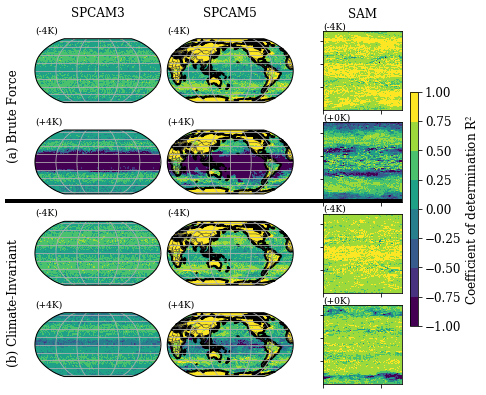

In [83]:
fig, ax = plt.subplots(4,3,subplot_kw={'projection':ccrs.Robinson(central_longitude=180)},figsize=(7,6.5))

for isub in range(12):
    ilin = int(np.floor(isub/3))
    icol = isub-3*ilin
    
    if ilin%2==0: 
        tit = '(-4K)'; 
        if icol==0: dataset = 'AQ-4K'; data = STaqua_m4K
        elif icol==1: dataset = 'RG-4K'; data = ST_m4K
    else: 
        tit = '(+4K)'
        if icol==0: dataset = 'AQ+4K'; data = STaqua_p4K
        elif icol==1: dataset = 'RG+4K'; data = ST_p4K
        
    if isub==0 or isub==3: toplot = R2_SPCAM[dataset]['2021_04_26_NN.hdf5']
    elif isub==1 or isub==4: toplot = R2_SPCAM[dataset]['2021_06_03_RG2AQ_NN.hdf5']
    elif isub==6 or isub==9: toplot = R2_SPCAM[dataset]['2021_04_26_NN_RH_TfromNS_LHF_nsDELQ.hdf5']
    elif isub==7 or isub==10: toplot =  R2_SPCAM[dataset]['2021_06_17_RG2AQ_NN_RH_BMSE_LHF_nsDELQ.hdf5']
    else: toplot = -toplot**0
    #print('isub = ',isub,'and mean R2 is ',np.mean(toplot.flatten()))
    imag = ax[ilin][icol].pcolormesh(data.lon, data.lat, 
                                     toplot,cmap=cmap_R2, norm=norm_R2,
                                     transform=ccrs.PlateCarree(),
                                     vmin=-1,vmax=1)
    ax[ilin][icol].gridlines()
    
    if icol%3==2: 
        ax[ilin][icol].remove()
        ax[ilin][icol] = fig.add_subplot(4,3,3*ilin+icol+1)
        if isub==2: toplot = R2_Janni['No_Climate_invar']['qobs']['Tout_lev0']; tit = '(-4K)'
        elif isub==5: toplot = R2_Janni['No_Climate_invar']['qobs4K']['Tout_lev0']; tit = '(+0K)'
        elif isub==8: toplot = R2_Janni['Climate_invar']['qobs']['Tout_lev0']; tit = '(-4K)'
        elif isub==11: toplot = R2_Janni['Climate_invar']['qobs4K']['Tout_lev0']; tit = '(+0K)'
        imag = ax[ilin][icol].pcolormesh(coor_Janni['x'],coor_Janni['y'],toplot.T,
                                                 cmap=cmap_R2,norm=norm_R2,
                                                 vmin=-1,vmax=1)
        ax[ilin][icol].set_aspect(0.4)
        ax[ilin][icol].xaxis.set_ticklabels([])
        ax[ilin][icol].yaxis.set_ticklabels([])
    
    
    if icol<2: ax[ilin][icol].set_title(tit,loc='left',fontsize=3*fz/4)
    else: ax[ilin][icol].set_title(tit,loc='left',fontsize=3*fz/4,pad=-0.1)
    if icol==1:
            ax[ilin][icol].coastlines(linewidth=2.0,edgecolor='0.25')
            ax[ilin][icol].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')

    # Colorbar
    if isub==0:
        cbar_ax = fig.add_axes(CBAR_position)
        CBAR = fig.colorbar(imag, label="Coefficient of determination R$^{2}$", cax=cbar_ax)
        cbar_ax.yaxis.set_ticks_position('right')
        cbar_ax.yaxis.set_label_position('right')

    # Title of each column
    if ilin==0:
        if isub<3: 
            TEXT[isub] = ax[0][isub].text(0.5,Y0,Titles[isub],fontsize=fz,
                                                   va='top',ha = 'center',
                                                   transform = ax[0][isub].transAxes)
            
plt.draw()
# Horizontal line in the middle
ys = 0.7*ax[1,0].get_position().y0+0.3*ax[2,0].get_position().y1
line = plt.Line2D([0.07,0.85],[ys,ys], transform=fig.transFigure, color="black")
fig.add_artist(line)
# Vertical text to indicate subplots
plt.text(0.07,0.7,'(a) Brute Force',rotation=90,va='center',transform=fig.transFigure, color="black");
plt.text(0.07,0.3,'(b) Climate-Invariant',rotation=90,va='center',transform=fig.transFigure, color="black");

plt.subplots_adjust(wspace=0.05, hspace=0.15)
TEXT[2].set_position((0.5,1.3))

plt.savefig(path_Fig+'FigS6.pdf', format='pdf')

# Fig S7 & S8

## Load data

In [207]:
hf = open(path_Fig+'SPCAM3_Visualization_Weights.pkl','rb')
MLR_S = pickle.load(hf)
hf.close()

In [208]:
MLR_S = MLR_S['weight']

## Plot figure S7

In [221]:
# For outputs
XTEXT = 67.5
YTEXT = 17
# For inputs
XINP = 17
YINP2 = 124
# For titles
YTIT = -5
# For colorbar
CBAR_position = [0.75, 0.25, 0.015, 0.5]
VMIN = -75; VMAX = 75

In [222]:
fz = 15
lw = 6
siz = 250

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

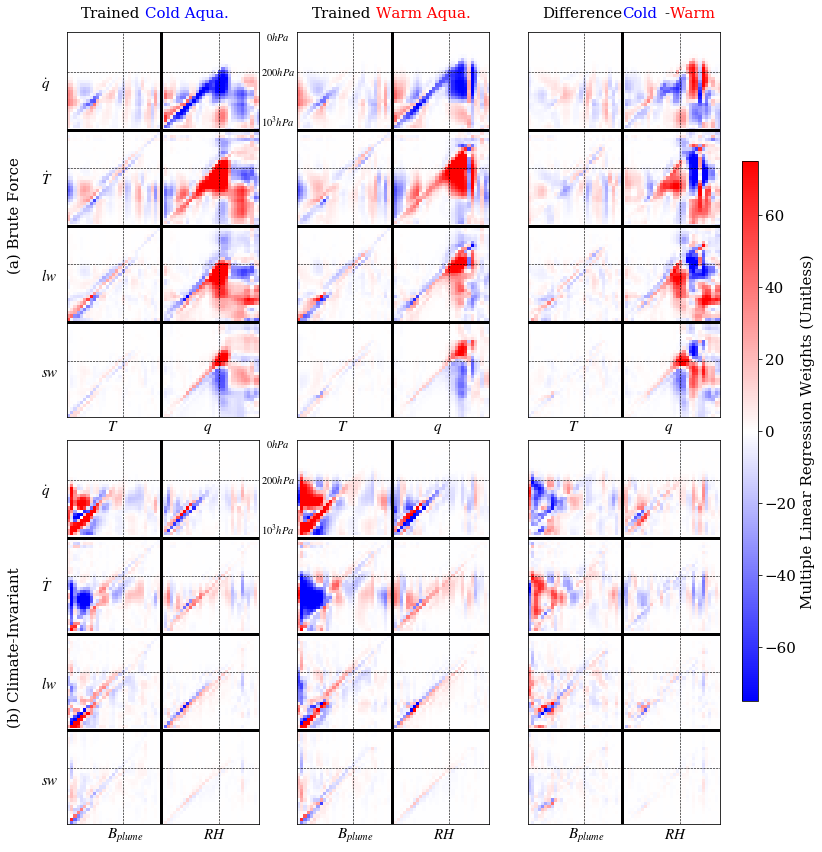

In [224]:
fig,ax = plt.subplots(2,3,figsize=(15,15))

for icol in range(3):
    for ilin in range(2):
    
        if ilin==0 and icol==0: 
            toplot = MLR_S['2021_04_26_MLR.hdf5'][:60,:].T
        elif ilin==0 and icol==1: 
            toplot = MLR_S['2021_04_27_W2C_MLR.hdf5'][:60,:].T
        elif ilin==0 and icol==2:
            toplot = (-1*MLR_S['2021_04_27_W2C_MLR.hdf5'][:60,:].T+\
            1*MLR_S['2021_04_26_MLR.hdf5'][:60,:].T)
        elif ilin==1 and icol==0: 
            toplot = MLR_S['2021_06_17_MLR_RH_BMSE_LHF_nsDELQ.hdf5'][:60,:].T
        elif ilin==1 and icol==1: 
            toplot = (MLR_S['2021_06_17_W2C_MLR_RH_BMSE_LHF_nsDELQ.hdf5'][:60,:].T)
        elif ilin==1 and icol==2:
            toplot = (MLR_S['2021_06_17_MLR_RH_BMSE_LHF_nsDELQ.hdf5'][:60,:].T-\
            MLR_S['2021_06_17_W2C_MLR_RH_BMSE_LHF_nsDELQ.hdf5'][:60,:].T)

        mapp = ax[ilin][icol].imshow(toplot,cmap='bwr',vmin=VMIN,vmax=VMAX)
        ax[ilin][icol].invert_xaxis()
        ax[ilin,icol].axvline(x=30,color='k',linewidth=lw/2)
        ax[ilin,icol].axvline(x=12,color='k',linewidth=lw/10,linestyle='--')
        ax[ilin,icol].axvline(x=42,color='k',linewidth=lw/10,linestyle='--')
        for ix,xline in enumerate([30,60,90]):
            ax[ilin,icol].axhline(y=xline,color='k',linewidth=lw/2)
        for ix,xline in enumerate([12,42,72,102]):
            ax[ilin,icol].axhline(y=xline,color='k',linewidth=lw/10,linestyle='--')
        ax[ilin,icol].set_xticks([])
        ax[ilin,icol].set_yticks([])
        
        # Colorbar
        if ilin==0 and icol==0:
            cbar_ax = fig.add_axes(CBAR_position)
            CBAR = fig.colorbar(mapp, label="Multiple Linear Regression Weights (Unitless)", cax=cbar_ax)
            cbar_ax.yaxis.set_ticks_position('right')
            cbar_ax.yaxis.set_label_position('right')
        
        # Output text
        if icol==0:
            ax[ilin,icol].text(XTEXT,YTEXT,'$\dot{q}$')
            ax[ilin,icol].text(XTEXT,30+YTEXT,'$\dot{T}$')
            ax[ilin,icol].text(XTEXT,60+YTEXT,'$lw$')
            ax[ilin,icol].text(XTEXT,90+YTEXT,'$sw$')
        # Vertical coordinate
        if icol==0:
            ax[ilin,icol].text(-6.5,2,'$0hPa$',fontsize=0.7*fz,ha='center')
            ax[ilin,icol].text(-6.5,13,'$200hPa$',fontsize=0.7*fz,ha='center')
            ax[ilin,icol].text(-6.5,29,'$10^{3}hPa$',fontsize=0.7*fz,ha='center')
        # Input text
        if ilin==0:
            ax[ilin,icol].text(XINP,YINP2,'$q$')
            ax[ilin,icol].text(XINP+30,YINP2,'$T$')
        elif ilin==1:
            ax[ilin,icol].text(XINP,YINP2,'$RH$')
            ax[ilin,icol].text(XINP+30,YINP2,'$B_{plume}$')
        # Titles
        if ilin==0:
            if icol==0:
                ax[ilin,icol].text(55,YTIT,'Trained',color='k')
                ax[ilin,icol].text(35,YTIT,'Cold Aqua.',fontsize=fz,color="blue")
            elif icol==1:
                ax[ilin,icol].text(55,YTIT,'Trained',color='k')
                ax[ilin,icol].text(35,YTIT,'Warm Aqua.',fontsize=fz,color="red")
            elif icol==2:
                ax[ilin,icol].text(55,YTIT,'Difference',color='k')
                ax[ilin,icol].text(30,YTIT,'Cold',fontsize=fz,color="blue")
                ax[ilin,icol].text(17,YTIT,'-',fontsize=fz,color='k')
                ax[ilin,icol].text(15,YTIT,'Warm',fontsize=fz,color='red')
        
        
plt.subplots_adjust(left=None, bottom=None, right=0.73, top=None, wspace=None,hspace=0)

plt.draw()

# Vertical text to indicate subplots
plt.text(0.07,0.7,'(a) Brute Force',rotation=90,va='center',transform=fig.transFigure, color="black");
plt.text(0.07,0.3,'(b) Climate-Invariant',rotation=90,va='center',transform=fig.transFigure, color="black");

plt.savefig(path_Fig+'FigS7.pdf', format='pdf')

## Plot Figure S8

In [217]:
fz = 10
lw = 6
siz = 250

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

In [218]:
COL = ['darkviolet','gold','forestgreen','royalblue']
# For outputs
XTEXT = -135
YTEXT = 17

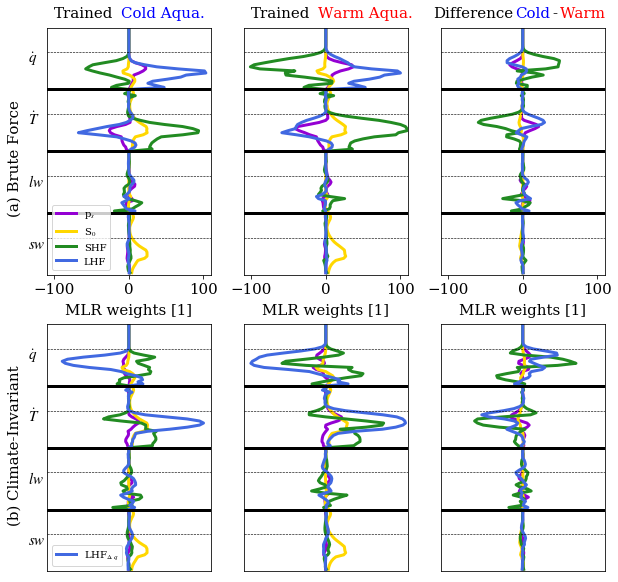

In [221]:
fig,ax = plt.subplots(2,3,figsize=(10,10))

for icol in range(3):
    for ilin in range(2):
        
        if ilin==0 and icol==0: 
            toplot = MLR_S['2021_04_26_MLR.hdf5']
        elif ilin==0 and icol==1: 
            toplot = MLR_S['2021_04_27_W2C_MLR.hdf5']
        elif ilin==0 and icol==2:
            toplot = (MLR_S['2021_04_26_MLR.hdf5']-\
            MLR_S['2021_04_27_W2C_MLR.hdf5'])
        elif ilin==1 and icol==0: 
            toplot = MLR_S['2021_06_17_MLR_RH_BMSE_LHF_nsDELQ.hdf5']
        elif ilin==1 and icol==1: 
            toplot = MLR_S['2021_06_17_W2C_MLR_RH_BMSE_LHF_nsDELQ.hdf5']
        elif ilin==1 and icol==2:
            toplot = (MLR_S['2021_06_17_MLR_RH_BMSE_LHF_nsDELQ.hdf5']-\
            MLR_S['2021_06_17_W2C_MLR_RH_BMSE_LHF_nsDELQ.hdf5'])
        
        if ilin==0: INP_dic = ['p$_{s}$','S$_{0}$','SHF','LHF']
        elif ilin==1: INP_dic = ['','','','LHF$_{\\Delta\\ q}$']
            
        for iinp in np.arange(60,64):
            ax[ilin,icol].plot(toplot[iinp,:],np.arange(0,120),
                      color=COL[iinp-60],linewidth=lw/2,label=INP_dic[iinp-60])
    
        plt.rc('font',size=fz)
        if ilin==0 and icol==0: ax[ilin,icol].legend(loc='lower left');
        if ilin==1 and icol==0: ax[ilin,icol].legend(loc='lower left')
        ax[ilin][icol].set_ylim((0,120))
        ax[ilin][icol].set_xlim((-110,110))
        ax[ilin][icol].invert_yaxis()
        for ix,xline in enumerate([30,60,90]):
            ax[ilin,icol].axhline(y=xline,color='k',linewidth=lw/2)
        for ix,xline in enumerate([12,42,72,102]):
            ax[ilin,icol].axhline(y=xline,color='k',linewidth=lw/10,linestyle='--')
        ax[ilin,icol].set_yticks([])
        if ilin==1: ax[ilin,icol].set_xticks([])
            
        plt.rc('font',size=1.5*fz)
        # Output text
        if icol==0:
            ax[ilin,icol].text(XTEXT,YTEXT,'$\dot{q}$')
            ax[ilin,icol].text(XTEXT,30+YTEXT,'$\dot{T}$')
            ax[ilin,icol].text(XTEXT,60+YTEXT,'$lw$')
            ax[ilin,icol].text(XTEXT,90+YTEXT,'$sw$')
        # Titles
        if ilin==0:
            if icol==0:
                ax[ilin,icol].text(-100,YTIT,'Trained',color='k')
                ax[ilin,icol].text(-10,YTIT,'Cold Aqua.',color="blue")
            elif icol==1:
                ax[ilin,icol].text(-100,YTIT,'Trained',color='k')
                ax[ilin,icol].text(-10,YTIT,'Warm Aqua.',color="red")
            elif icol==2:
                ax[ilin,icol].text(-120,YTIT,'Difference',color='k')
                ax[ilin,icol].text(-10,YTIT,'Cold',color="blue")
                ax[ilin,icol].text(40,YTIT,'-',color='k')
                ax[ilin,icol].text(50,YTIT,'Warm',color='red')
        elif ilin==1:
            ax[ilin,icol].text(0,-5,'MLR weights [1]',ha='center')
        plt.rc('font',size=fz)
        
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2)

plt.rc('font',size=1.5*fz)
# Vertical text to indicate subplots
plt.text(0.07,0.7,'(a) Brute Force',rotation=90,va='center',transform=fig.transFigure, color="black");
plt.text(0.07,0.3,'(b) Climate-Invariant',rotation=90,va='center',transform=fig.transFigure, color="black");

plt.savefig(path_Fig+'FigS8.pdf', format='pdf')

# Fig S9 & S10

## Load data

In [225]:
hf = open(path_Fig+'SPCAM3_Jacobian.pkl','rb')
Jacobian = pickle.load(hf)
hf.close()

In [226]:
BF = Jacobian['BF']
BFW2C = Jacobian['BFW2C']
CI = Jacobian['CI']
CIW2C = Jacobian['CIW2C']

## Plot Fig S9

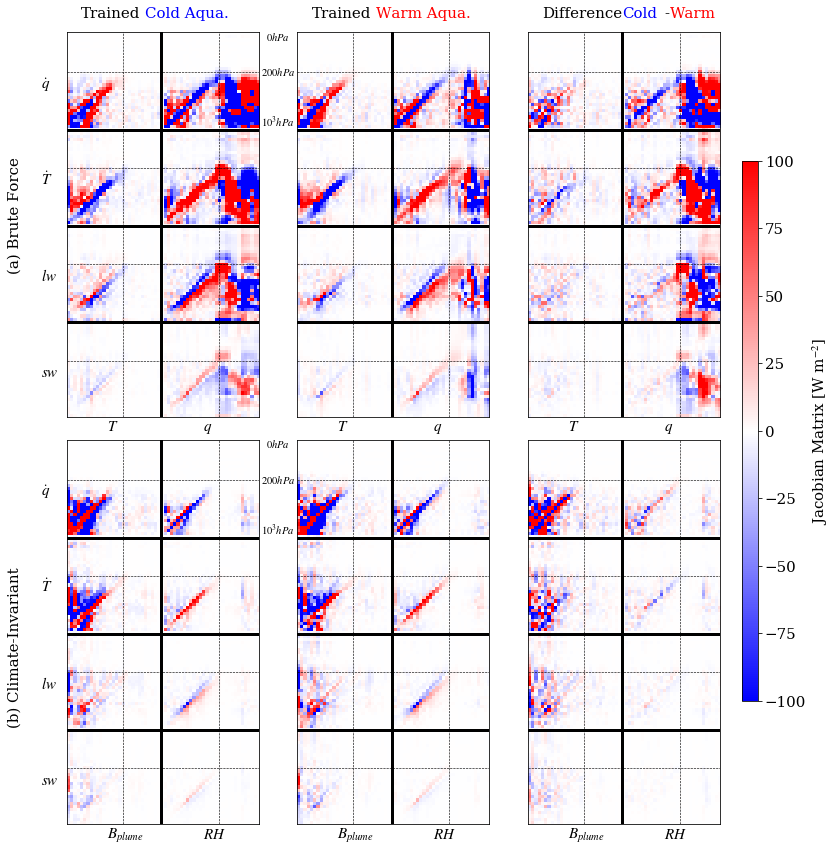

In [227]:
# For outputs
XTEXT = 67.5
YTEXT = 17
# For inputs
XINP = 17
YINP2 = 124
# For titles
YTIT = -5
# For colorbar
CBAR_position = [0.75, 0.25, 0.015, 0.5]
VMIN = -100; VMAX = 100

fz = 15
lw = 6
siz = 250

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

fig,ax = plt.subplots(2,3,figsize=(15,15))

for icol in range(3):
    for ilin in range(2):
    
        if ilin==0 and icol==0: 
            toplot = BF[:60,:].T
        elif ilin==0 and icol==1: 
            toplot = BFW2C[:60,:].T
        elif ilin==0 and icol==2:
            toplot = (-1*BFW2C[:60,:].T+1*BF[:60,:].T)
        elif ilin==1 and icol==0: 
            toplot = CI[:60,:].T
        elif ilin==1 and icol==1: 
            toplot = (CIW2C[:60,:].T)
        elif ilin==1 and icol==2:
            toplot = (CI[:60,:].T-CIW2C[:60,:].T)

        mapp = ax[ilin][icol].imshow(toplot,cmap='bwr',vmin=VMIN,vmax=VMAX)
        ax[ilin][icol].invert_xaxis()
        ax[ilin,icol].axvline(x=30,color='k',linewidth=lw/2)
        ax[ilin,icol].axvline(x=12,color='k',linewidth=lw/10,linestyle='--')
        ax[ilin,icol].axvline(x=42,color='k',linewidth=lw/10,linestyle='--')
        for ix,xline in enumerate([30,60,90]):
            ax[ilin,icol].axhline(y=xline,color='k',linewidth=lw/2)
        for ix,xline in enumerate([12,42,72,102]):
            ax[ilin,icol].axhline(y=xline,color='k',linewidth=lw/10,linestyle='--')
        ax[ilin,icol].set_xticks([])
        ax[ilin,icol].set_yticks([])
        
        # Colorbar
        if ilin==0 and icol==0:
            cbar_ax = fig.add_axes(CBAR_position)
            CBAR = fig.colorbar(mapp, label="Jacobian Matrix [W m$^{-2}$]", cax=cbar_ax)
            cbar_ax.yaxis.set_ticks_position('right')
            cbar_ax.yaxis.set_label_position('right')
        
        # Output text
        if icol==0:
            ax[ilin,icol].text(XTEXT,YTEXT,'$\dot{q}$')
            ax[ilin,icol].text(XTEXT,30+YTEXT,'$\dot{T}$')
            ax[ilin,icol].text(XTEXT,60+YTEXT,'$lw$')
            ax[ilin,icol].text(XTEXT,90+YTEXT,'$sw$')
        # Vertical coordinate
        if icol==0:
            ax[ilin,icol].text(-6.5,2,'$0hPa$',fontsize=0.7*fz,ha='center')
            ax[ilin,icol].text(-6.5,13,'$200hPa$',fontsize=0.7*fz,ha='center')
            ax[ilin,icol].text(-6.5,29,'$10^{3}hPa$',fontsize=0.7*fz,ha='center')
        # Input text
        if ilin==0:
            ax[ilin,icol].text(XINP,YINP2,'$q$')
            ax[ilin,icol].text(XINP+30,YINP2,'$T$')
        elif ilin==1:
            ax[ilin,icol].text(XINP,YINP2,'$RH$')
            ax[ilin,icol].text(XINP+30,YINP2,'$B_{plume}$')
        # Titles
        if ilin==0:
            if icol==0:
                ax[ilin,icol].text(55,YTIT,'Trained',color='k')
                ax[ilin,icol].text(35,YTIT,'Cold Aqua.',fontsize=fz,color="blue")
            elif icol==1:
                ax[ilin,icol].text(55,YTIT,'Trained',color='k')
                ax[ilin,icol].text(35,YTIT,'Warm Aqua.',fontsize=fz,color="red")
            elif icol==2:
                ax[ilin,icol].text(55,YTIT,'Difference',color='k')
                ax[ilin,icol].text(30,YTIT,'Cold',fontsize=fz,color="blue")
                ax[ilin,icol].text(17,YTIT,'-',fontsize=fz,color='k')
                ax[ilin,icol].text(15,YTIT,'Warm',fontsize=fz,color='red')
        
        
plt.subplots_adjust(left=None, bottom=None, right=0.73, top=None, wspace=None, hspace=0)

plt.draw()

# Vertical text to indicate subplots
plt.text(0.07,0.7,'(a) Brute Force',rotation=90,va='center',transform=fig.transFigure, color="black");
plt.text(0.07,0.3,'(b) Climate-Invariant',rotation=90,va='center',transform=fig.transFigure, color="black");

plt.savefig(path_Fig+'FigS9.pdf', format='pdf')

## Plot FigS10

In [190]:
fz = 10
lw = 6
siz = 250

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')
COL = ['darkviolet','gold','forestgreen','royalblue']
# For outputs
XTEXT = -200
YTEXT = 17

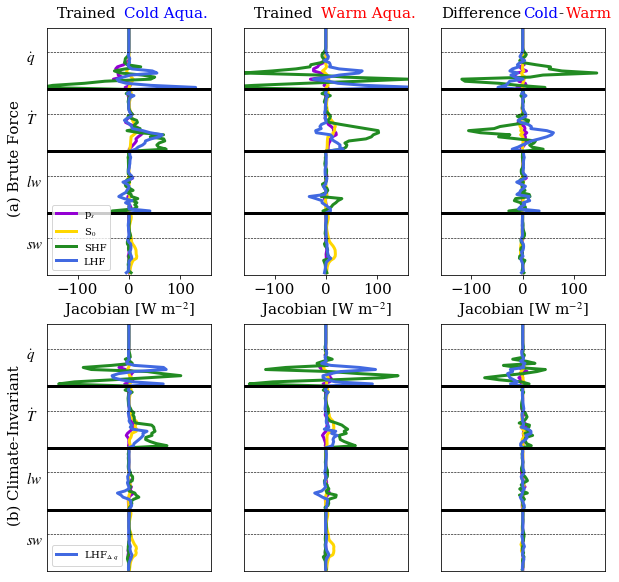

In [197]:
fig,ax = plt.subplots(2,3,figsize=(10,10))

for icol in range(3):
    for ilin in range(2):
        
        if ilin==0 and icol==0: 
            toplot = BF
        elif ilin==0 and icol==1: 
            toplot = BFW2C
        elif ilin==0 and icol==2:
            toplot = (BF-BFW2C)
        elif ilin==1 and icol==0: 
            toplot = CI
        elif ilin==1 and icol==1: 
            toplot = CIW2C
        elif ilin==1 and icol==2:
            toplot = (CI-CIW2C)
        
        if ilin==0: INP_dic = ['p$_{s}$','S$_{0}$','SHF','LHF']
        elif ilin==1: INP_dic = ['','','','LHF$_{\\Delta\\ q}$']
            
        for iinp in np.arange(60,64):
            ax[ilin,icol].plot(toplot[iinp,:],np.arange(0,120),
                      color=COL[iinp-60],linewidth=lw/2,label=INP_dic[iinp-60])
    
        plt.rc('font',size=fz)
        if ilin==0 and icol==0: ax[ilin,icol].legend(loc='lower left');
        if ilin==1 and icol==0: ax[ilin,icol].legend(loc='lower left')
        ax[ilin][icol].set_ylim((0,120))
        ax[ilin][icol].set_xlim((-160,160))
        ax[ilin][icol].invert_yaxis()
        for ix,xline in enumerate([30,60,90]):
            ax[ilin,icol].axhline(y=xline,color='k',linewidth=lw/2)
        for ix,xline in enumerate([12,42,72,102]):
            ax[ilin,icol].axhline(y=xline,color='k',linewidth=lw/10,linestyle='--')
        ax[ilin,icol].set_yticks([])
        if ilin==1: ax[ilin,icol].set_xticks([])
            
        plt.rc('font',size=1.5*fz)
        # Output text
        if icol==0:
            ax[ilin,icol].text(XTEXT,YTEXT,'$\dot{q}$')
            ax[ilin,icol].text(XTEXT,30+YTEXT,'$\dot{T}$')
            ax[ilin,icol].text(XTEXT,60+YTEXT,'$lw$')
            ax[ilin,icol].text(XTEXT,90+YTEXT,'$sw$')
        # Titles
        if ilin==0:
            if icol==0:
                ax[ilin,icol].text(-140,YTIT,'Trained',color='k')
                ax[ilin,icol].text(-10,YTIT,'Cold Aqua.',color="blue")
            elif icol==1:
                ax[ilin,icol].text(-140,YTIT,'Trained',color='k')
                ax[ilin,icol].text(-10,YTIT,'Warm Aqua.',color="red")
            elif icol==2:
                ax[ilin,icol].text(-160,YTIT,'Difference',color='k')
                ax[ilin,icol].text(0,YTIT,'Cold',color="blue")
                ax[ilin,icol].text(70,YTIT,'-',color='k')
                ax[ilin,icol].text(85,YTIT,'Warm',color='red')
        elif ilin==1:
            ax[ilin,icol].text(0,-5,'Jacobian [W m$^{-2}$]',ha='center')
        plt.rc('font',size=fz)
        
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2)

plt.rc('font',size=1.5*fz)
# Vertical text to indicate subplots
plt.text(0.07,0.7,'(a) Brute Force',rotation=90,va='center',transform=fig.transFigure, color="black");
plt.text(0.07,0.3,'(b) Climate-Invariant',rotation=90,va='center',transform=fig.transFigure, color="black");

plt.savefig(path_Fig+'FigS10.pdf', format='pdf')

# Fig S11 & S12

## Load data

In [228]:
hf = open(path_Fig+'SPCAM3_SHAP_Matrix.pkl','rb')
SHAP_toplot = pickle.load(hf)
hf.close()

In [229]:
SHAP_toplot = SHAP_toplot['SHAP_toplot']

## Plot Figure S11

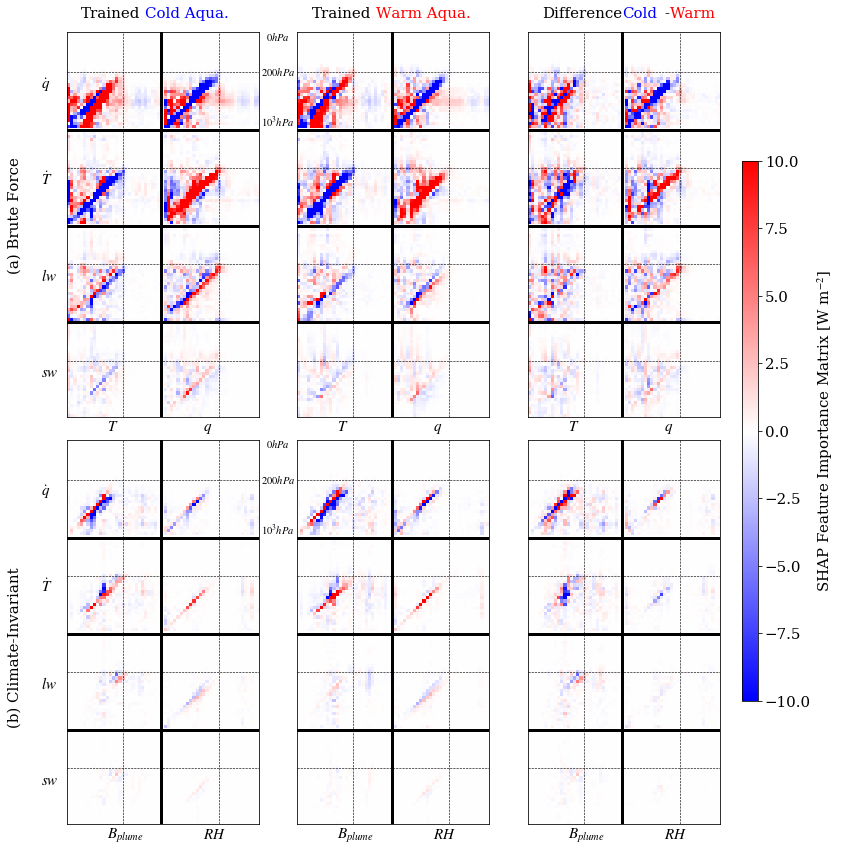

In [231]:
# For outputs
XTEXT = 67.5
YTEXT = 17
# For inputs
XINP = 17
YINP2 = 124
# For titles
YTIT = -5
# For colorbar
CBAR_position = [0.75, 0.25, 0.015, 0.5]
VMIN = -10; VMAX = 10

fac_conf = 1 # Multiplicative factor for conferences (set to 1 for paper, 4 for conferences)

fz = fac_conf*15
lw = (fac_conf**0.5)*6
siz = 250

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

S = SHAP_toplot

fig,ax = plt.subplots(2,3,figsize=(fac_conf*15,fac_conf*15))

for icol in range(3):
    for ilin in range(2):
    
        if ilin==0 and icol==0: 
            toplot = S['2021_04_26_NN.hdf5'][:60,:].T
        elif ilin==0 and icol==1: 
            toplot = S['2021_04_27_W2C_NN.hdf5'][:60,:].T
        elif ilin==0 and icol==2:
            toplot = (-1*S['2021_04_27_W2C_NN.hdf5'][:60,:].T+\
            1*S['2021_04_26_NN.hdf5'][:60,:].T)
        elif ilin==1 and icol==0: 
            toplot = S['2021_06_17_NN_RH_BMSE_LHF_nsDELQ.hdf5'][:60,:].T
        elif ilin==1 and icol==1: 
            toplot = (S['2021_06_17_W2C_NN_RH_BMSE_LHF_nsDELQ.hdf5'][:60,:].T)
        elif ilin==1 and icol==2:
            toplot = (S['2021_06_17_NN_RH_BMSE_LHF_nsDELQ.hdf5'][:60,:].T-\
            S['2021_06_17_W2C_NN_RH_BMSE_LHF_nsDELQ.hdf5'][:60,:].T)

        mapp = ax[ilin][icol].imshow(toplot,cmap='bwr',vmin=VMIN,vmax=VMAX)
        ax[ilin][icol].invert_xaxis()
        ax[ilin,icol].axvline(x=30,color='k',linewidth=lw/2)
        ax[ilin,icol].axvline(x=12,color='k',linewidth=lw/10,linestyle='--')
        ax[ilin,icol].axvline(x=42,color='k',linewidth=lw/10,linestyle='--')
        for ix,xline in enumerate([30,60,90]):
            ax[ilin,icol].axhline(y=xline,color='k',linewidth=lw/2)
        for ix,xline in enumerate([12,42,72,102]):
            ax[ilin,icol].axhline(y=xline,color='k',linewidth=lw/10,linestyle='--')
        ax[ilin,icol].set_xticks([])
        ax[ilin,icol].set_yticks([])
        
        # Colorbar
        if ilin==0 and icol==0:
            cbar_ax = fig.add_axes(CBAR_position)
            CBAR = fig.colorbar(mapp, label="SHAP Feature Importance Matrix [W m$^{-2}$]", cax=cbar_ax)
            cbar_ax.yaxis.set_ticks_position('right')
            cbar_ax.yaxis.set_label_position('right')
        
        # Output text
        if icol==0:
            ax[ilin,icol].text(XTEXT,YTEXT,'$\dot{q}$')
            ax[ilin,icol].text(XTEXT,30+YTEXT,'$\dot{T}$')
            ax[ilin,icol].text(XTEXT,60+YTEXT,'$lw$')
            ax[ilin,icol].text(XTEXT,90+YTEXT,'$sw$')
        # Vertical coordinate
        if icol==0:
            ax[ilin,icol].text(-6.5,2,'$0hPa$',fontsize=0.7*fz,ha='center')
            ax[ilin,icol].text(-6.5,13,'$200hPa$',fontsize=0.7*fz,ha='center')
            ax[ilin,icol].text(-6.5,29,'$10^{3}hPa$',fontsize=0.7*fz,ha='center')
        # Input text
        if ilin==0:
            ax[ilin,icol].text(XINP,YINP2,'$q$')
            ax[ilin,icol].text(XINP+30,YINP2,'$T$')
        elif ilin==1:
            ax[ilin,icol].text(XINP,YINP2,'$RH$')
            ax[ilin,icol].text(XINP+30,YINP2,'$B_{plume}$')
        # Titles
        if ilin==0:
            if icol==0:
                ax[ilin,icol].text(55,YTIT,'Trained',color='k')
                ax[ilin,icol].text(35,YTIT,'Cold Aqua.',fontsize=fz,color="blue")
            elif icol==1:
                ax[ilin,icol].text(55,YTIT,'Trained',color='k')
                ax[ilin,icol].text(35,YTIT,'Warm Aqua.',fontsize=fz,color="red")
            elif icol==2:
                ax[ilin,icol].text(55,YTIT,'Difference',color='k')
                ax[ilin,icol].text(30,YTIT,'Cold',fontsize=fz,color="blue")
                ax[ilin,icol].text(17,YTIT,'-',fontsize=fz,color='k')
                ax[ilin,icol].text(15,YTIT,'Warm',fontsize=fz,color='red')
        
        
plt.subplots_adjust(left=None, bottom=None, right=0.73, top=None, wspace=None, hspace=0)

plt.draw()

# Vertical text to indicate subplots
plt.text(0.07,0.7,'(a) Brute Force',rotation=90,va='center',transform=fig.transFigure, color="black");
plt.text(0.07,0.3,'(b) Climate-Invariant',rotation=90,va='center',transform=fig.transFigure, color="black");

plt.savefig(path_Fig+'FigS11.pdf', format='pdf')

## Plot Figure S12

In [246]:
fz = 10
lw = 6
siz = 250

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

COL = ['darkviolet','gold','forestgreen','royalblue']
# For outputs
XTEXT = -2
YTEXT = 17

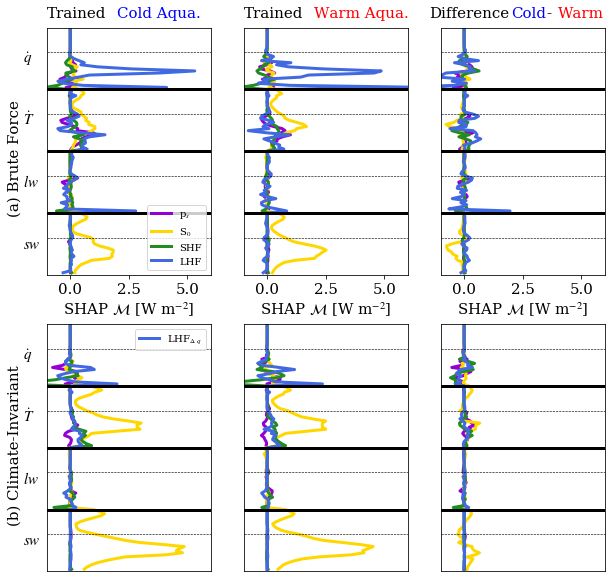

In [252]:
fig,ax = plt.subplots(2,3,figsize=(10,10))

for icol in range(3):
    for ilin in range(2):
        
        if ilin==0 and icol==0: 
            toplot = S['2021_04_26_NN.hdf5']
        elif ilin==0 and icol==1: 
            toplot = S['2021_04_27_W2C_NN.hdf5']
        elif ilin==0 and icol==2:
            toplot = (S['2021_04_26_NN.hdf5']-\
            S['2021_04_27_W2C_NN.hdf5'])
        elif ilin==1 and icol==0: 
            toplot = S['2021_06_17_NN_RH_BMSE_LHF_nsDELQ.hdf5']
        elif ilin==1 and icol==1: 
            toplot = S['2021_06_17_W2C_NN_RH_BMSE_LHF_nsDELQ.hdf5']
        elif ilin==1 and icol==2:
            toplot = (S['2021_06_17_NN_RH_BMSE_LHF_nsDELQ.hdf5']-\
            S['2021_06_17_W2C_NN_RH_BMSE_LHF_nsDELQ.hdf5'])
        
        if ilin==0: INP_dic = ['p$_{s}$','S$_{0}$','SHF','LHF']
        elif ilin==1: INP_dic = ['','','','LHF$_{\\Delta\\ q}$']
            
        for iinp in np.arange(60,64):
            ax[ilin,icol].plot(toplot[iinp,:],np.arange(0,120),
                      color=COL[iinp-60],linewidth=lw/2,label=INP_dic[iinp-60])
    
        plt.rc('font',size=fz)
        if ilin==0 and icol==0: ax[ilin,icol].legend(loc='lower right');
        if ilin==1 and icol==0: ax[ilin,icol].legend(loc='top right')
        ax[ilin][icol].set_ylim((0,120))
        ax[ilin][icol].set_xlim((-1,6))
        ax[ilin][icol].invert_yaxis()
        for ix,xline in enumerate([30,60,90]):
            ax[ilin,icol].axhline(y=xline,color='k',linewidth=lw/2)
        for ix,xline in enumerate([12,42,72,102]):
            ax[ilin,icol].axhline(y=xline,color='k',linewidth=lw/10,linestyle='--')
        ax[ilin,icol].set_yticks([])
        if ilin==1: ax[ilin,icol].set_xticks([])
            
        plt.rc('font',size=1.5*fz)
        # Output text
        if icol==0:
            ax[ilin,icol].text(XTEXT,YTEXT,'$\dot{q}$')
            ax[ilin,icol].text(XTEXT,30+YTEXT,'$\dot{T}$')
            ax[ilin,icol].text(XTEXT,60+YTEXT,'$lw$')
            ax[ilin,icol].text(XTEXT,90+YTEXT,'$sw$')
        # Titles
        if ilin==0:
            if icol==0:
                ax[ilin,icol].text(-1,YTIT,'Trained',color='k')
                ax[ilin,icol].text(2,YTIT,'Cold Aqua.',color="blue")
            elif icol==1:
                ax[ilin,icol].text(-1,YTIT,'Trained',color='k')
                ax[ilin,icol].text(2,YTIT,'Warm Aqua.',color="red")
            elif icol==2:
                ax[ilin,icol].text(-1.5,YTIT,'Difference',color='k')
                ax[ilin,icol].text(2,YTIT,'Cold',color="blue")
                ax[ilin,icol].text(3.5,YTIT,'-',color='k')
                ax[ilin,icol].text(4,YTIT,'Warm',color='red')
        elif ilin==1:
            ax[ilin,icol].text(2.5,-5,'SHAP ${\calM} $ [W m$^{-2}$]',ha='center')
        plt.rc('font',size=fz)
        
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.2)

plt.rc('font',size=1.5*fz)
# Vertical text to indicate subplots
plt.text(0.07,0.7,'(a) Brute Force',rotation=90,va='center',transform=fig.transFigure, color="black");
plt.text(0.07,0.3,'(b) Climate-Invariant',rotation=90,va='center',transform=fig.transFigure, color="black");

plt.savefig(path_Fig+'FigS12.pdf', format='pdf')